In [1]:
import numpy as np
import cv2
import pandas as pd
import string
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
with open('dataiam/iam_words/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]
print(len)

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [3]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [4]:
images = []
labels = []

RECORDS_COUNT = 500

In [5]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [6]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [7]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'dataiam/iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [8]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [9]:
train_padded_label.shape, valid_padded_label.shape

((396, 14), (46, 14))

In [10]:

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [11]:
train_images.shape

(396, 32, 128, 1)

In [12]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [13]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [14]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [15]:
# Define the directory path within /kaggle/output/
checkpoint_directory = 'working/checkpoint_1/' # /kaggle/output/checkpoint_1/

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_directory):
    os.makedirs(checkpoint_directory)  # Use os.makedirs() to create parent directories if needed

# Now you can save your data or model checkpoints to the checkpoint_directory
# For example, if you want to save a model checkpoint:
# model.save(os.path.join(checkpoint_directory, 'my_model.h5'))

In [16]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="working/checkpoint_1/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [17]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30



Epoch 1: val_loss improved from inf to 22.29278, saving model to working/checkpoint_1\sgdo-500r-30e-396t-46v.hdf5
50/50 - 26s - loss: 21.5654 - accuracy: 0.0000e+00 - val_loss: 22.2928 - val_accuracy: 0.0000e+00 - 26s/epoch - 529ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 22.29278
50/50 - 18s - loss: 16.4946 - accuracy: 0.0000e+00 - val_loss: 50.5756 - val_accuracy: 0.0000e+00 - 18s/epoch - 353ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 22.29278
50/50 - 15s - loss: 16.6658 - accuracy: 0.0000e+00 - val_loss: 23.5338 - val_accuracy: 0.0000e+00 - 15s/epoch - 306ms/step
Epoch 4/30

Epoch 4: val_loss improved from 22.29278 to 17.75918, saving model to working/checkpoint_1\sgdo-500r-30e-396t-46v.hdf5
50/50 - 15s - loss: 15.3497 - accuracy: 0.0000e+00 - val_loss: 17.7592 - val_accuracy: 0.0000e+00 - 15s/epoch - 298ms/step
Epoch 5/30

Epoch 5: val_loss improved from 17.75918 to 16.52655, saving model to working/checkpoint_1\sgdo-500r-30e-396t-46v.hdf5
50/50 - 14s

In [18]:
# Saving the history object in excel file using pandas. 
# pip install openpyxl 

history_dict = {
    'epoch': list(range(1, len(history.history['loss']) + 1)),
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}
history_df = pd.DataFrame(history_dict)
excel_file_path = 'working/training_history.xlsx'  # Replace with your desired file path
history_df.to_excel(excel_file_path, index=False)

In [19]:
!pip install -q python-levenshtein

In [20]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

2/2 [==============================] - 2s 111ms/step
jaro : 0.5206780538302277
ratio: 0.4228803804890761


13/13 [==============================] - 3s 191ms/step
original_text =   MOVE
predicted text = 19

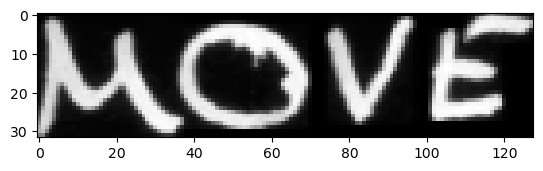



original_text =   to
predicted text = to

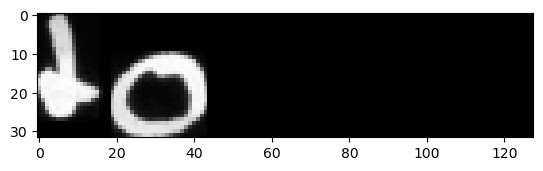



original_text =   stop
predicted text = f

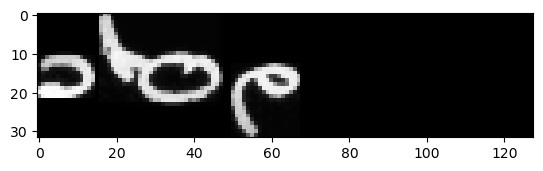



original_text =   Mr.
predicted text = Mf

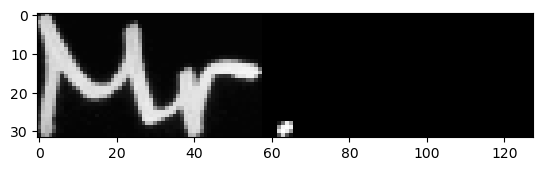



original_text =   Gaitskell
predicted text = Fao

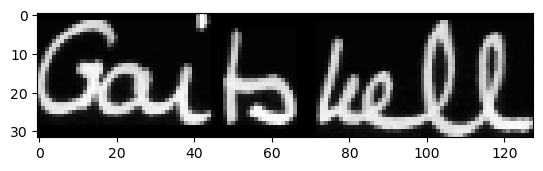



original_text =   from
predicted text = fo

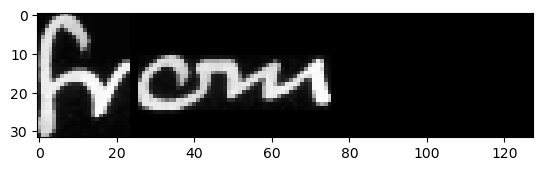



original_text =   nominating
predicted text = mt

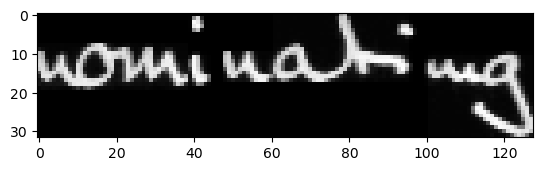



original_text =   any
predicted text = an

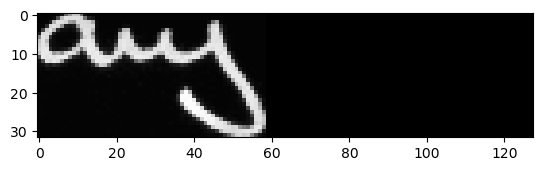



original_text =   more
predicted text = mo

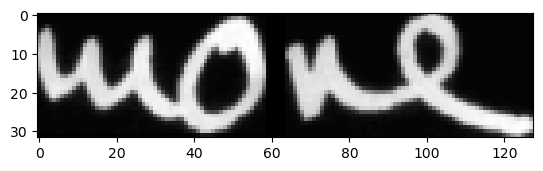



original_text =   life
predicted text = li

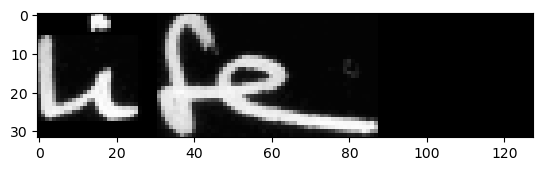



original_text =   Peers
predicted text = P

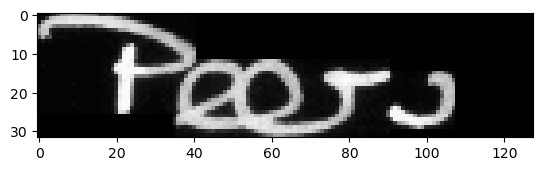



original_text =   is
predicted text = i

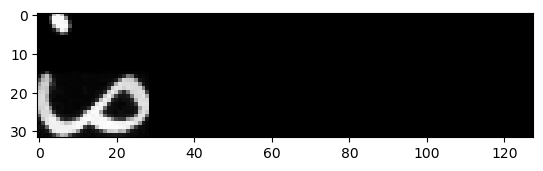



original_text =   to
predicted text = to

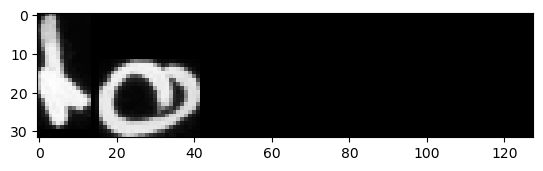



original_text =   be
predicted text = be

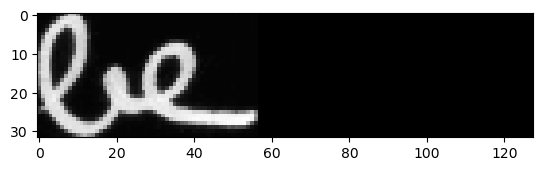



original_text =   made
predicted text = ma

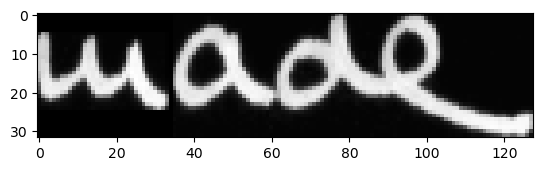



original_text =   at
predicted text = t

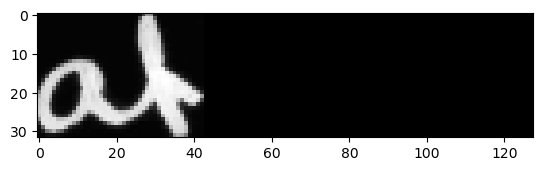



original_text =   a
predicted text = a

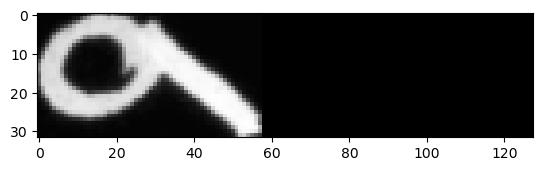



original_text =   meeting
predicted text = me

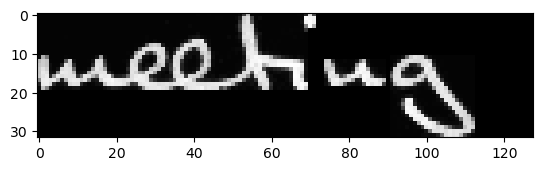



original_text =   Labour
predicted text = Laou

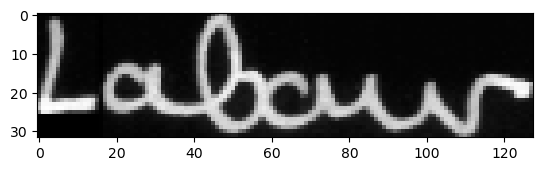



original_text =   put
predicted text = pt

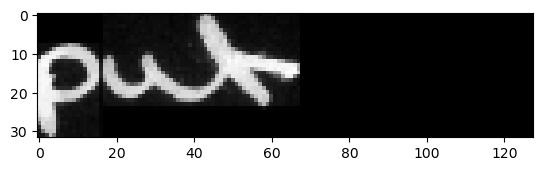



original_text =   a
predicted text = a

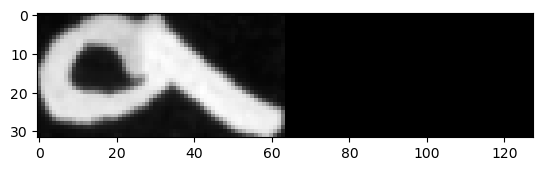



original_text =   resolution
predicted text = et

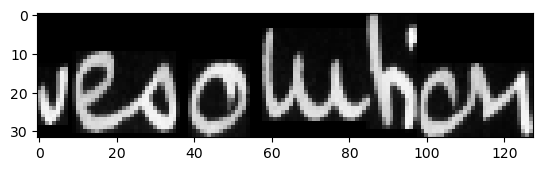



original_text =   on
predicted text = an

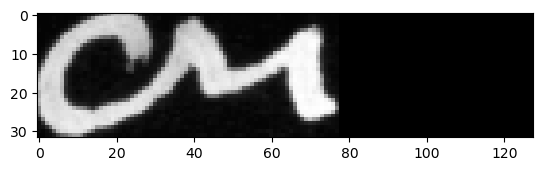



original_text =   the
predicted text = th

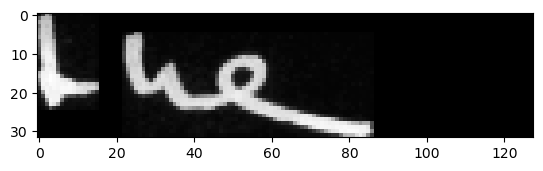



original_text =   subject
predicted text = mt

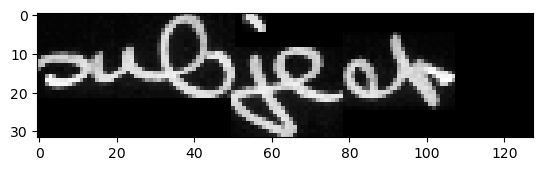



original_text =   Griffiths
predicted text = Fit

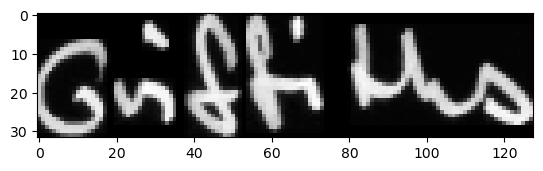



original_text =   ,
predicted text = ,

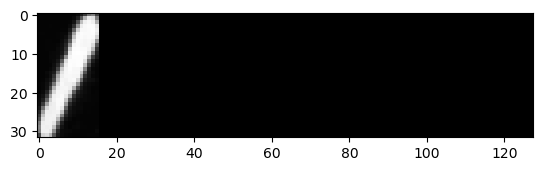



original_text =   MP
predicted text = M

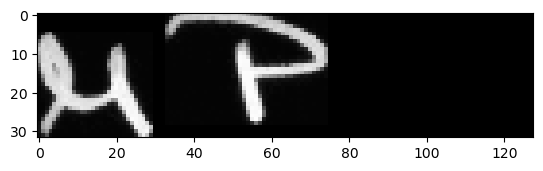



original_text =   for
predicted text = fo

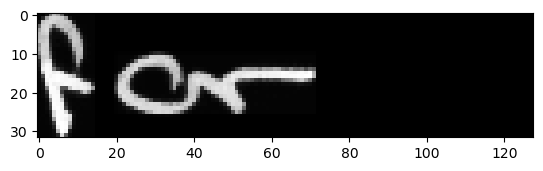



original_text =   Manchester
predicted text = taote

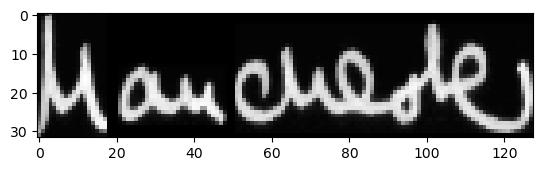



original_text =   .
predicted text = .

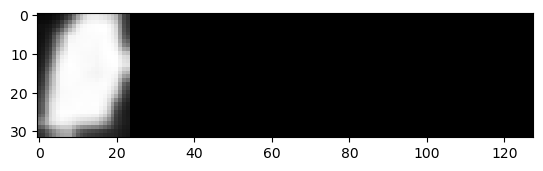



original_text =   A
predicted text = f

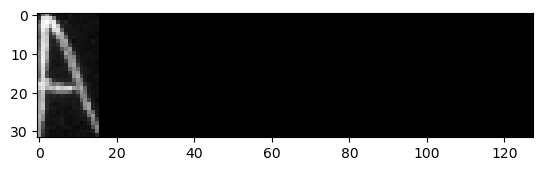



original_text =   MOVE
predicted text = ME

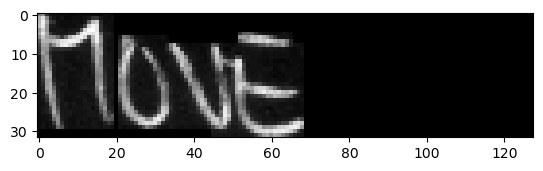



original_text =   to
predicted text = to

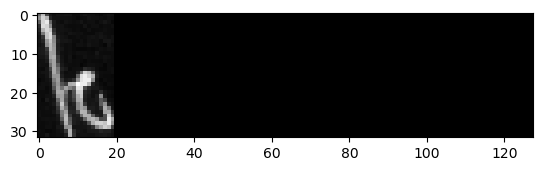



original_text =   stop
predicted text = tie

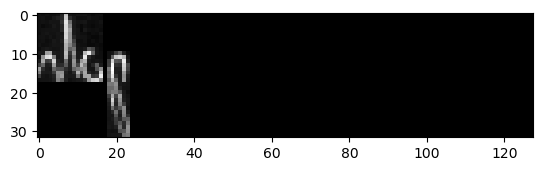



original_text =   Mr.
predicted text = Mr.

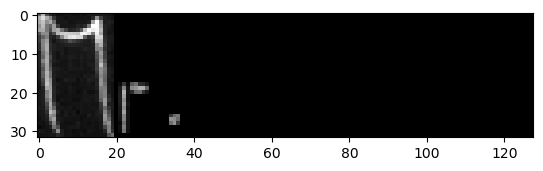



original_text =   Gaitskell
predicted text = Lai

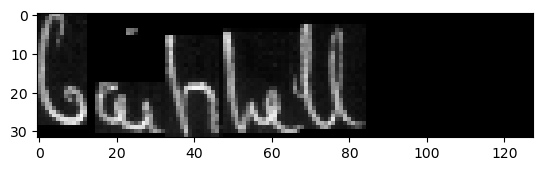



original_text =   from
predicted text = tfe

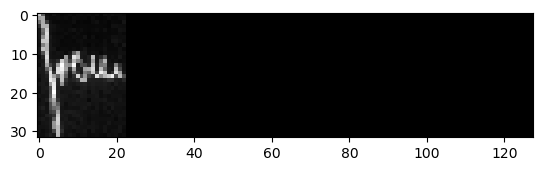



original_text =   nominating
predicted text = mi

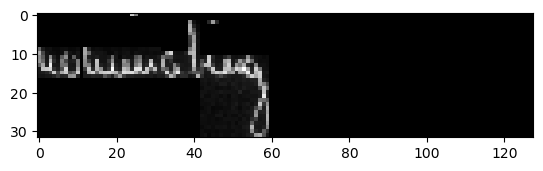



original_text =   more
predicted text = Mo

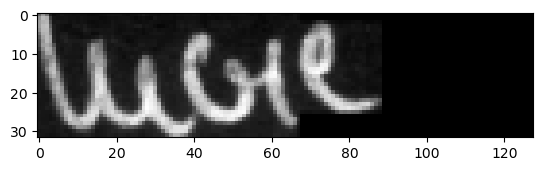



original_text =   Labour
predicted text = Labou

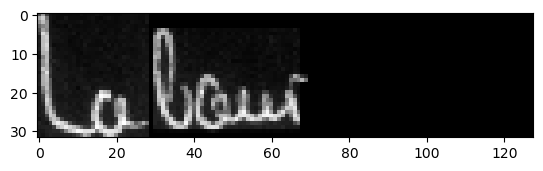



original_text =   life
predicted text = lf

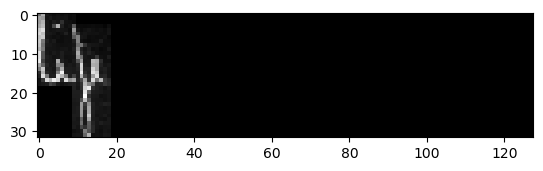



original_text =   Peers
predicted text = Pe

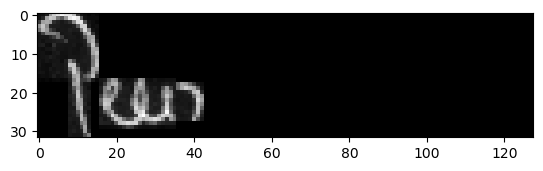



original_text =   is
predicted text = io

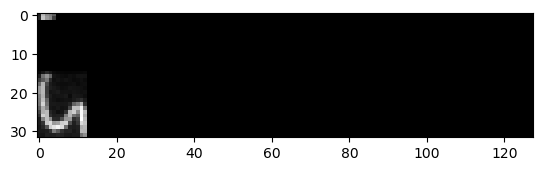



original_text =   to
predicted text = to

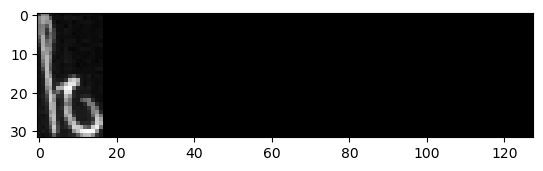



original_text =   be
predicted text = be

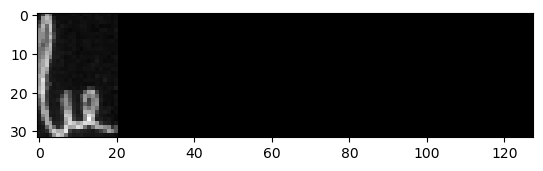



original_text =   made
predicted text = nt

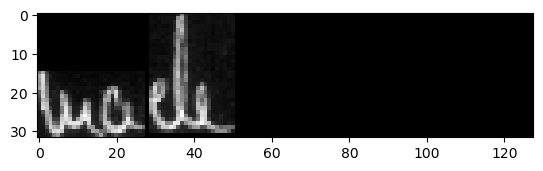



original_text =   at
predicted text = to

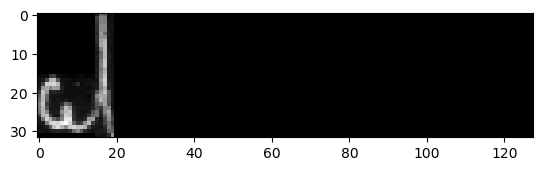



original_text =   meeting
predicted text = meit

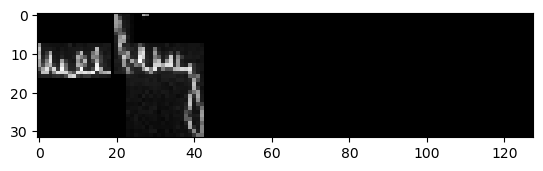



original_text =   of
predicted text = f

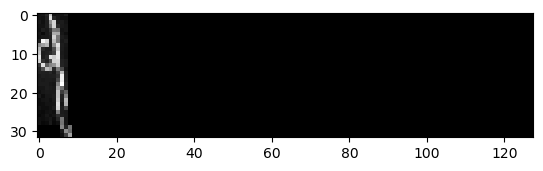



original_text =   Labour
predicted text = Labou

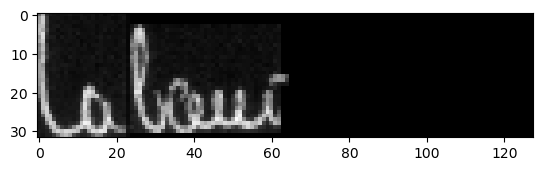



original_text =   0MPs
predicted text = MP

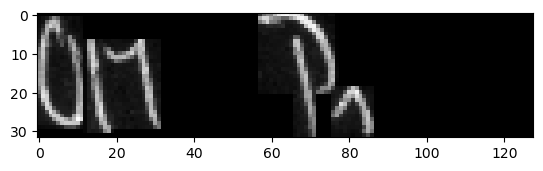



original_text =   tomorrow
predicted text = ao

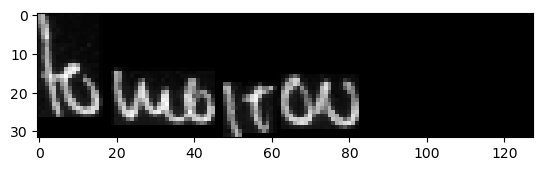



original_text =   .
predicted text = .

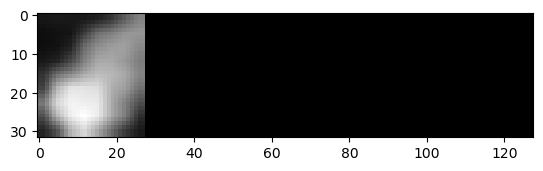



original_text =   Mr.
predicted text = M.

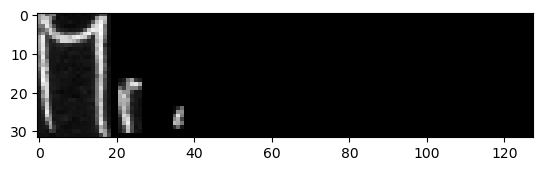



original_text =   Michael
predicted text = Mic

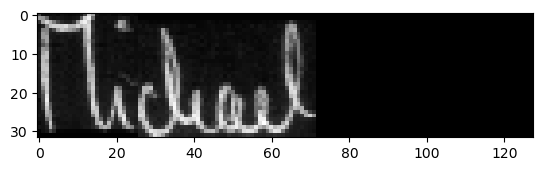



original_text =   Foot
predicted text = io

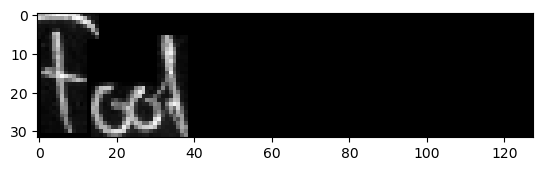



original_text =   put
predicted text = f

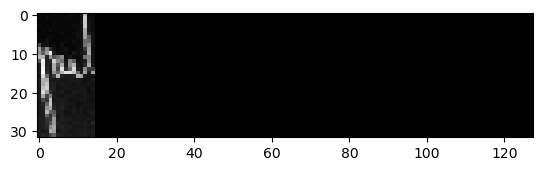



original_text =   down
predicted text = ba

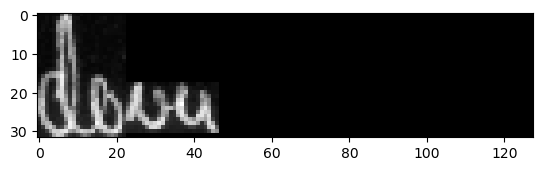



original_text =   a
predicted text = b

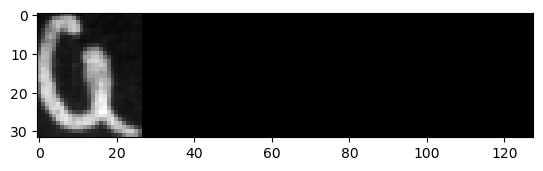



original_text =   resolution
predicted text = set

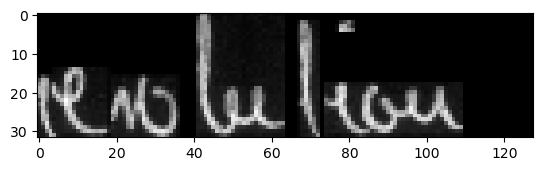



original_text =   on
predicted text = bo

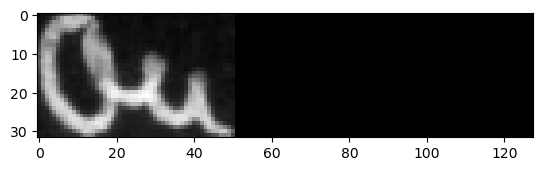



original_text =   the
predicted text = toe

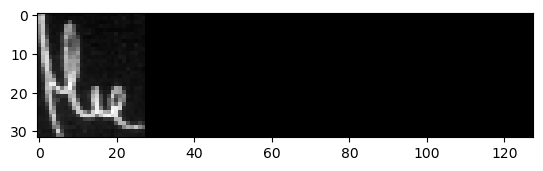



original_text =   subject
predicted text = fuit

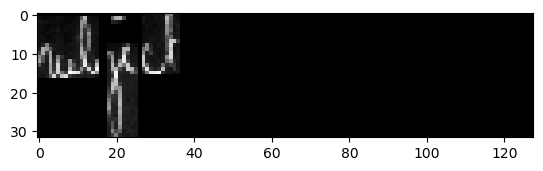



original_text =   and
predicted text = i

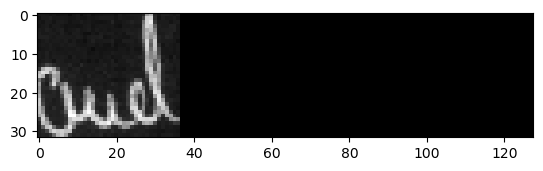



original_text =   he
predicted text = be

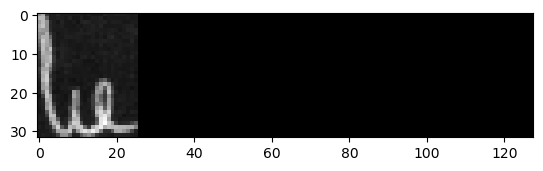



original_text =   to
predicted text = to

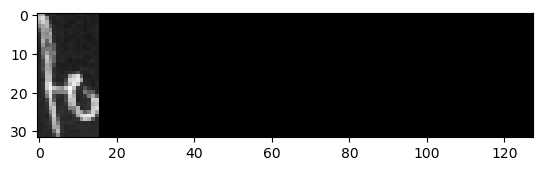



original_text =   be
predicted text = be

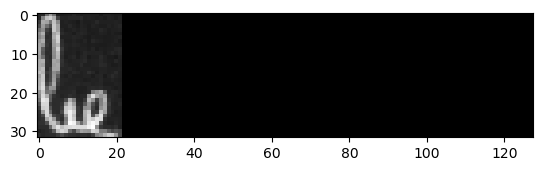



original_text =   backed
predicted text = Lai

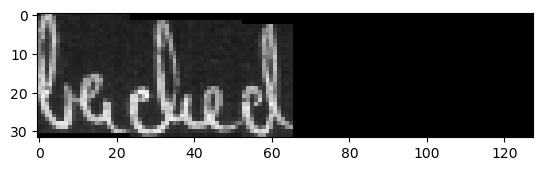



original_text =   by
predicted text = tf

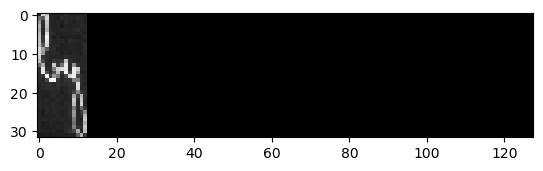



original_text =   Mr.
predicted text = M.

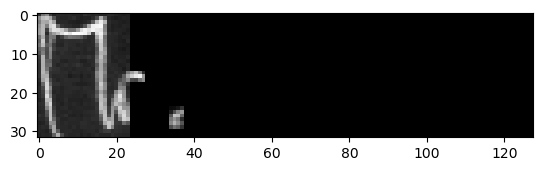



original_text =   Will
predicted text = i

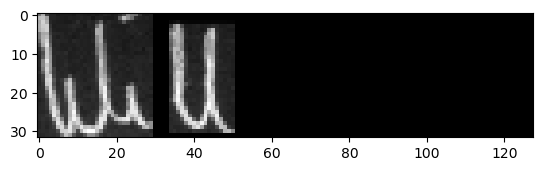



original_text =   Griffiths
predicted text = lfit

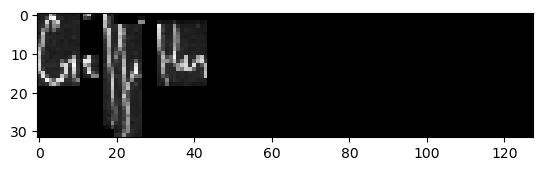



original_text =   ,
predicted text = ,

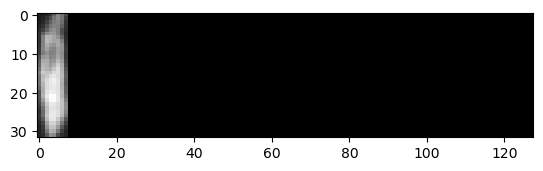



original_text =   0MP
predicted text = MP

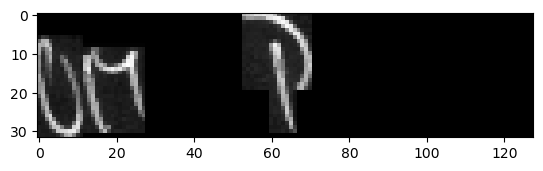



original_text =   Manchester
predicted text = La

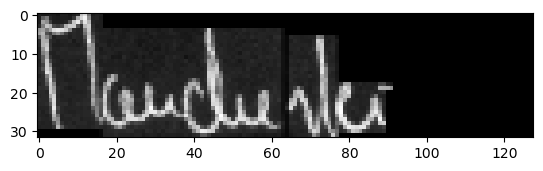



original_text =   Exchange
predicted text = fei

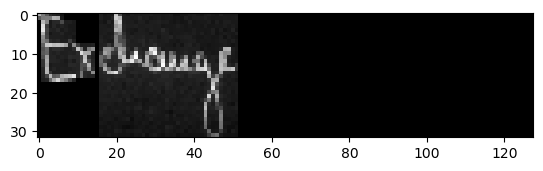



original_text =   .
predicted text = .

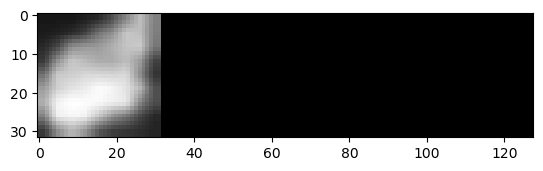



original_text =   Though
predicted text = o

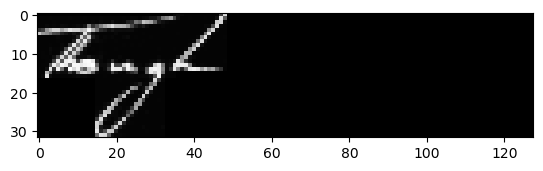



original_text =   they
predicted text = t

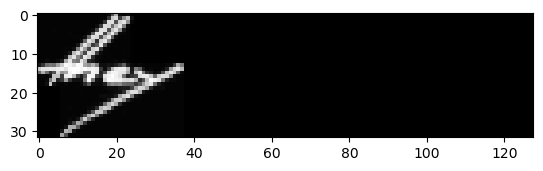



original_text =   may
predicted text = a

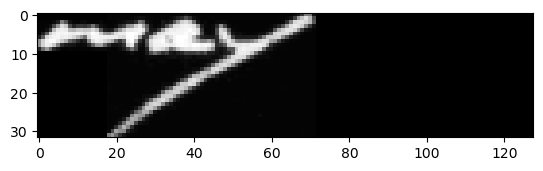



original_text =   gather
predicted text = pt

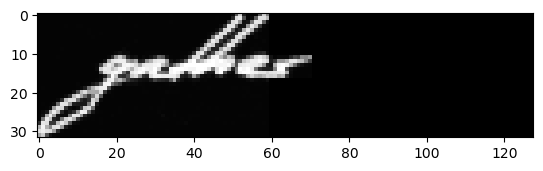



original_text =   some
predicted text = bo

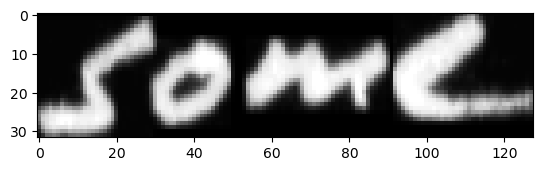



original_text =   Left-wing
predicted text = ft

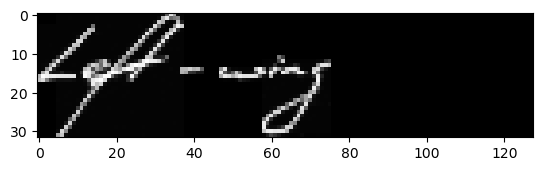



original_text =   ,
predicted text = ,

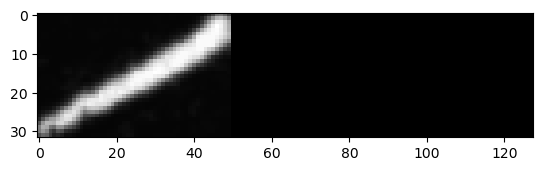



original_text =   a
predicted text = a

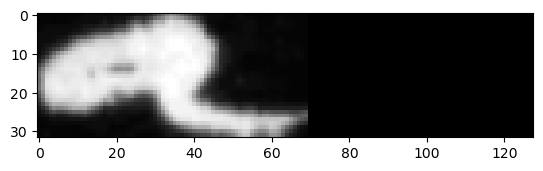



original_text =   large
predicted text = lre

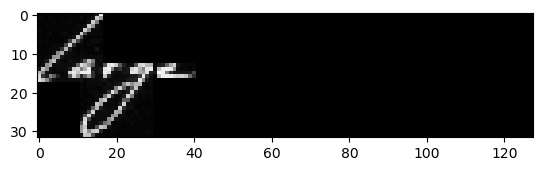



original_text =   majority
predicted text = mt

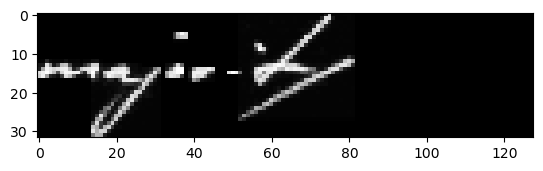



original_text =   of
predicted text = of

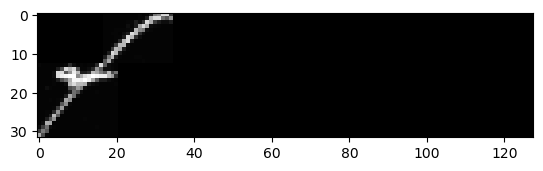



original_text =   Labour
predicted text = Lbo

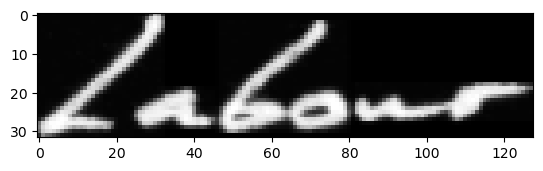



original_text =   MPs
predicted text = MPs

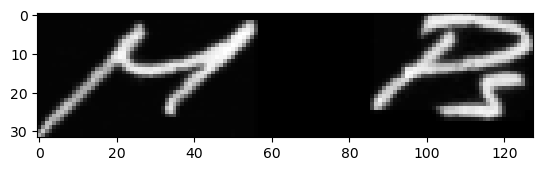



original_text =   are
predicted text = a

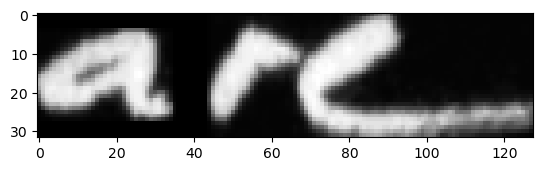



original_text =   likely
predicted text = li

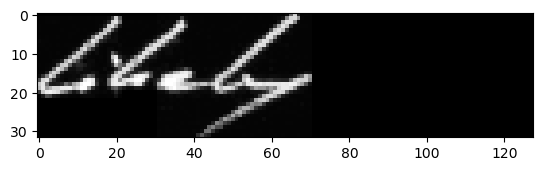



original_text =   turn
predicted text = to

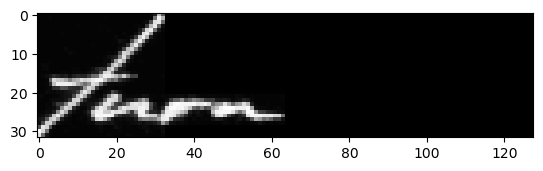



original_text =   down
predicted text = io

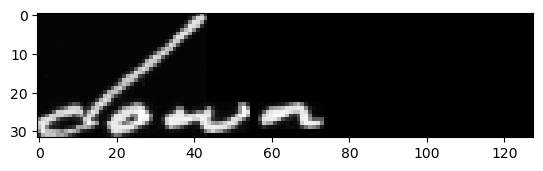



original_text =   the
predicted text = the

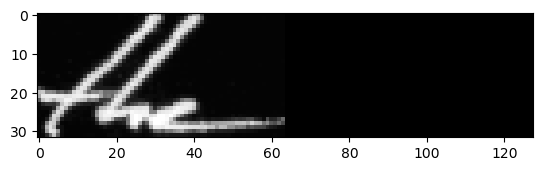



original_text =   Foot-Griffiths
predicted text = Fo

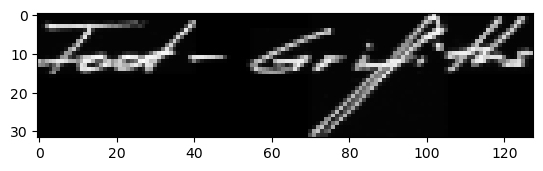



original_text =   resolution
predicted text = netio

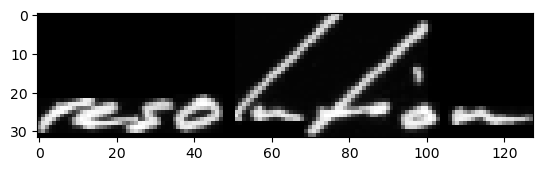



original_text =   .
predicted text = .

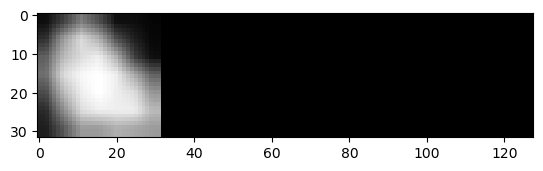



original_text =   Mr.
predicted text = ,

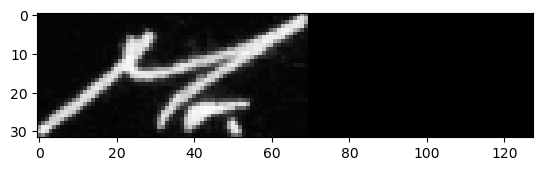



original_text =   Foot's
predicted text = Fot

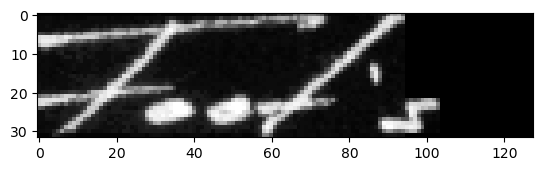



original_text =   line
predicted text = bo

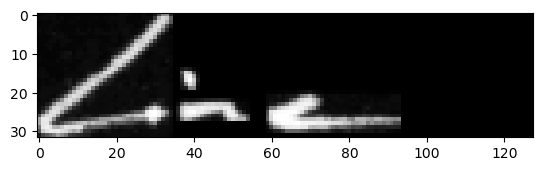



original_text =   be
predicted text = be

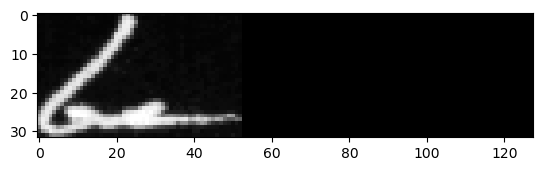



original_text =   that
predicted text = t

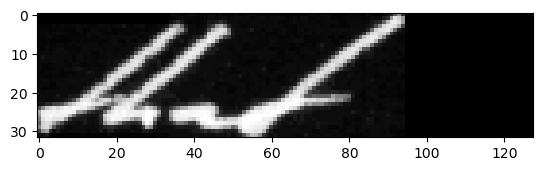



original_text =   as
predicted text = a

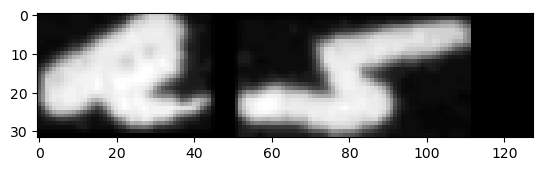



original_text =   Labour
predicted text = Lbo

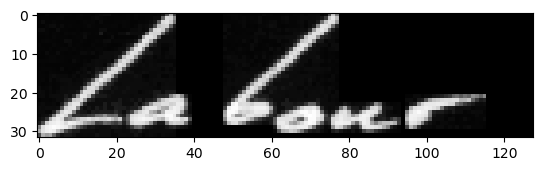



original_text =   MPs
predicted text = MP

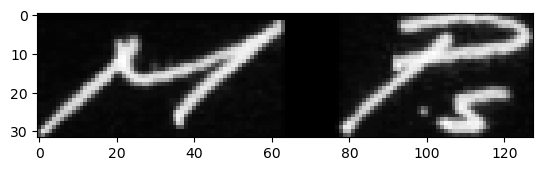



original_text =   opposed
predicted text = p

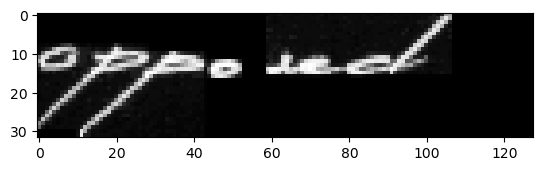



original_text =   the
predicted text = te

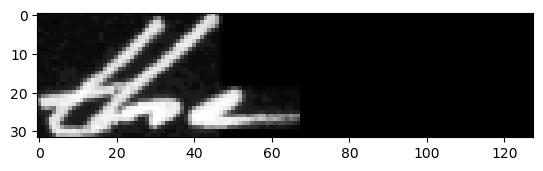



original_text =   Government
predicted text = Lot

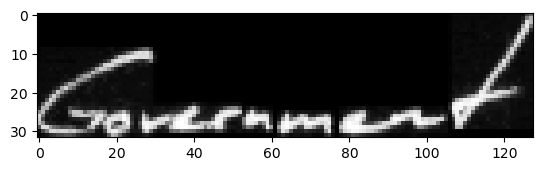



original_text =   Bill
predicted text = Bil

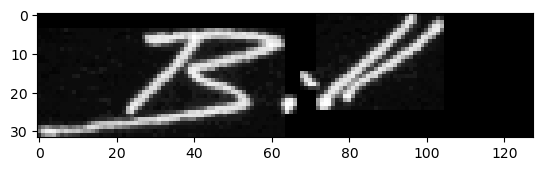



original_text =   brought
predicted text = fot

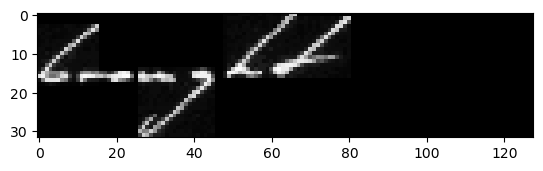



original_text =   life
predicted text = lf

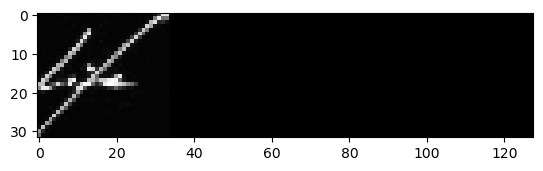



original_text =   peers
predicted text = p

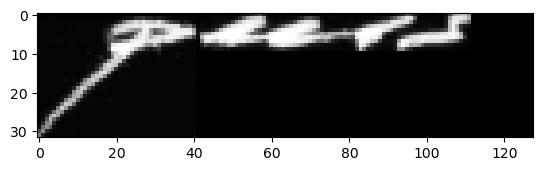



original_text =   into
predicted text = int

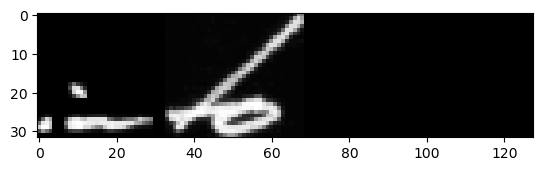



original_text =   existence
predicted text = et

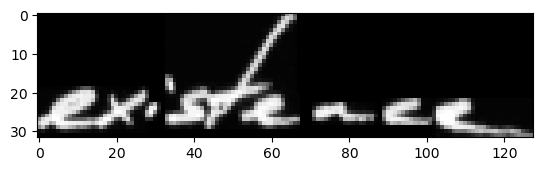



original_text =   ,
predicted text = ,

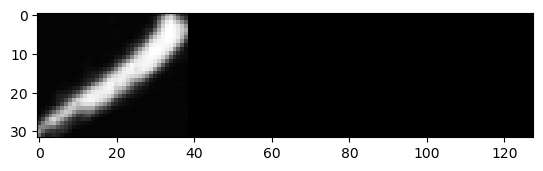



original_text =   they
predicted text = te

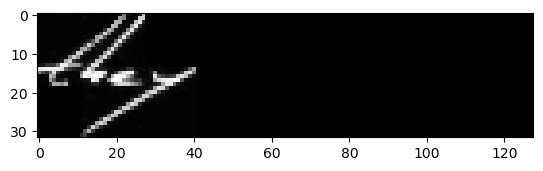



original_text =   should
predicted text = sol

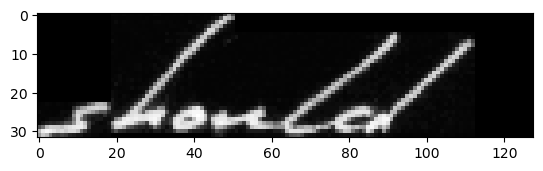



original_text =   not
predicted text = not

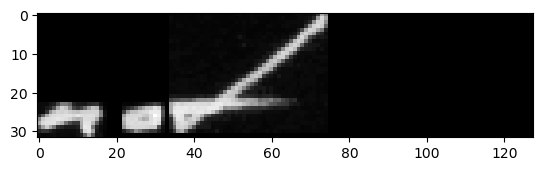



original_text =   put
predicted text = pt

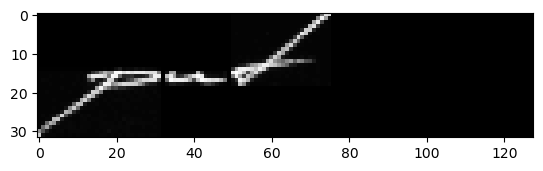



original_text =   forward
predicted text = fo

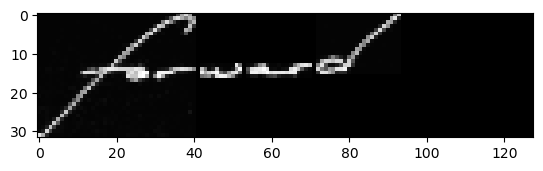



original_text =   nominees
predicted text = nee

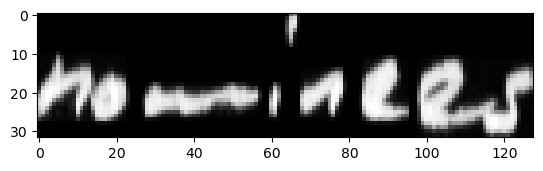



original_text =   .
predicted text = .

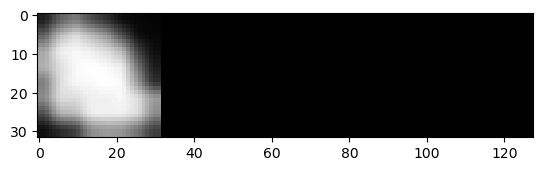



original_text =   He
predicted text = the

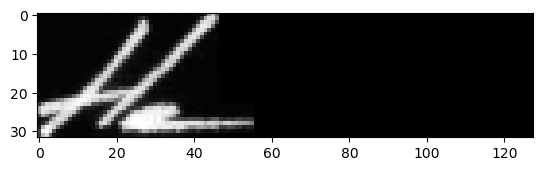



original_text =   believes
predicted text = Lb

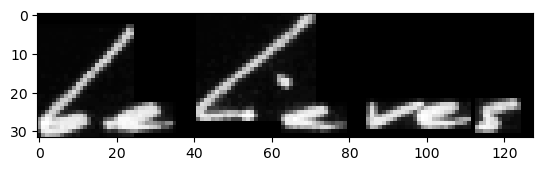



original_text =   that
predicted text = tt

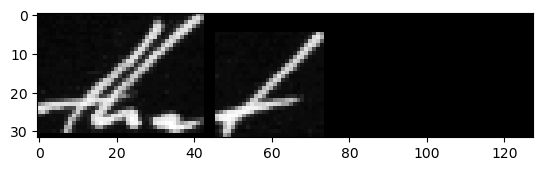



original_text =   the
predicted text = te

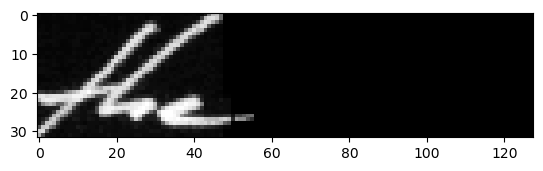



original_text =   House
predicted text = to

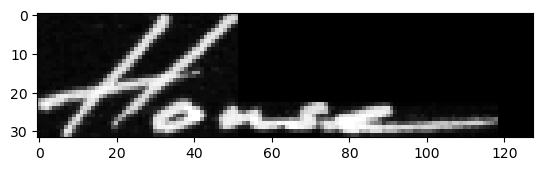



original_text =   Lords
predicted text = Lo

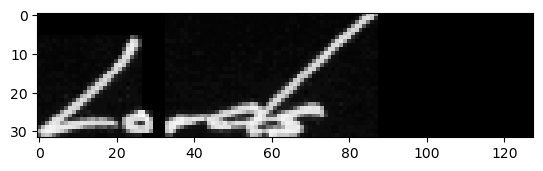



original_text =   should
predicted text = soul

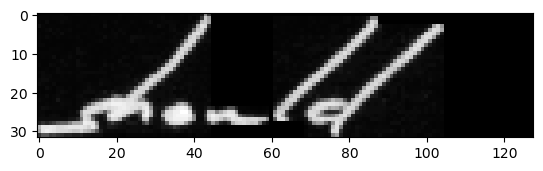



original_text =   be
predicted text = be

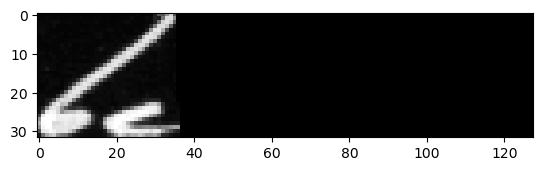



original_text =   abolished
predicted text = so

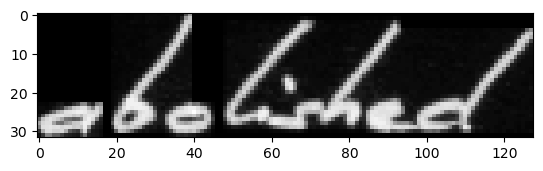



original_text =   and
predicted text = nt

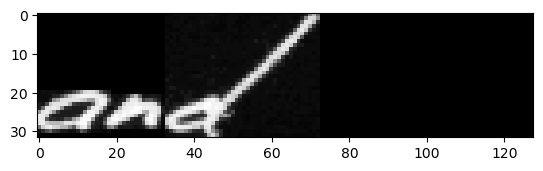



original_text =   that
predicted text = t

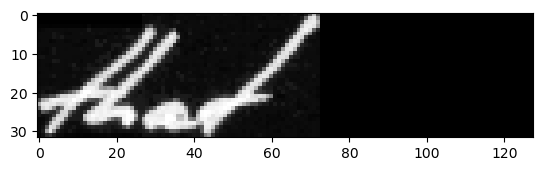



original_text =   Labour
predicted text = Lbo

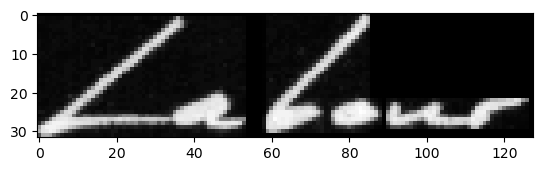



original_text =   should
predicted text = soul

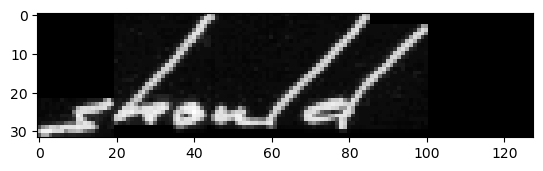



original_text =   not
predicted text = not

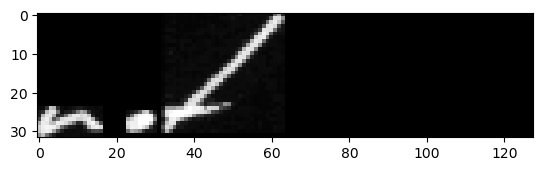



original_text =   any
predicted text = a

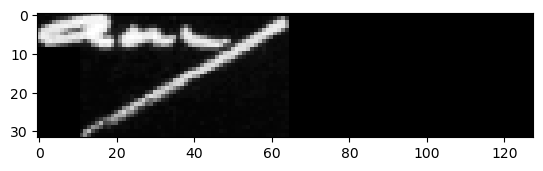



original_text =   steps
predicted text = sf

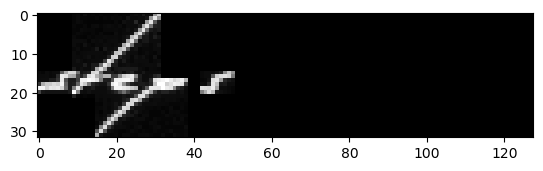



original_text =   institution
predicted text = sto

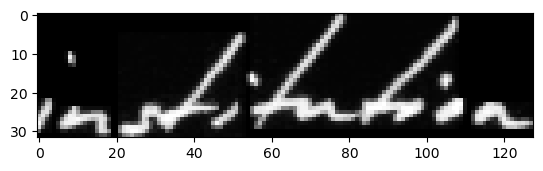



original_text =   .
predicted text = .

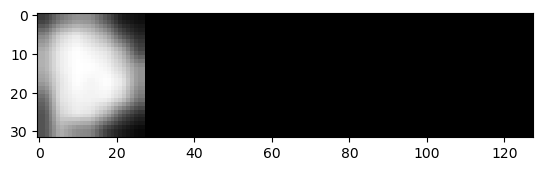



original_text =   Though
predicted text = To

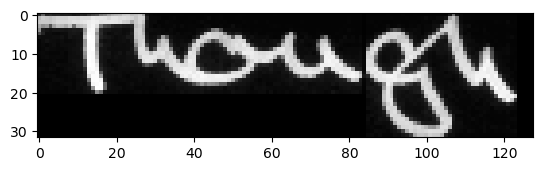



original_text =   they
predicted text = th

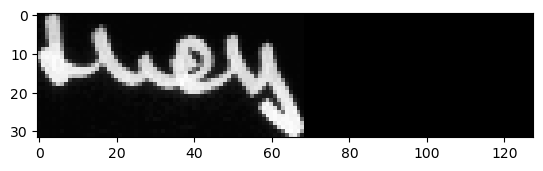



original_text =   may
predicted text = a

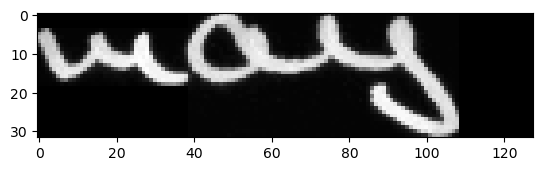



original_text =   gather
predicted text = p

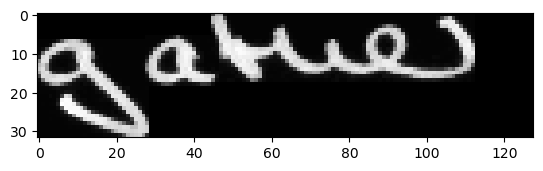



original_text =   some
predicted text = ao

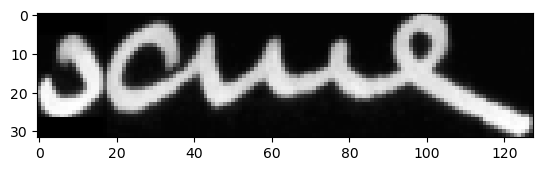



original_text =   support
predicted text = aot

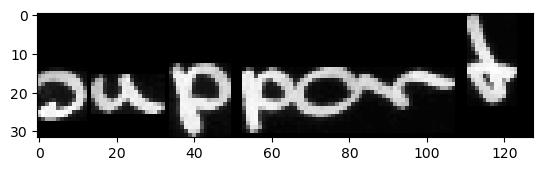



original_text =   ,
predicted text = ,

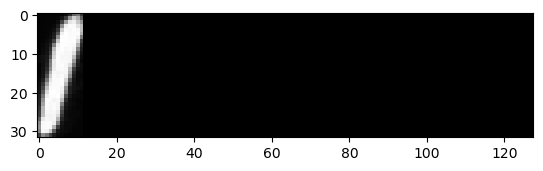



original_text =   a
predicted text = a

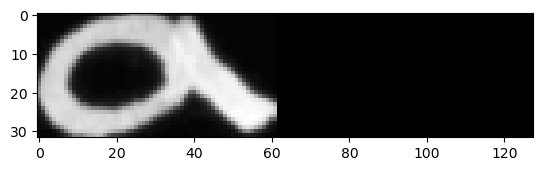



original_text =   large
predicted text = a

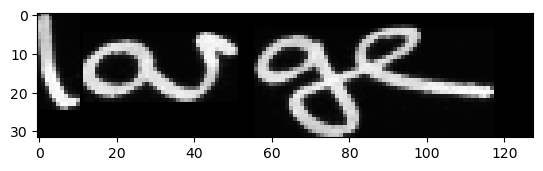



original_text =   majority
predicted text = mot

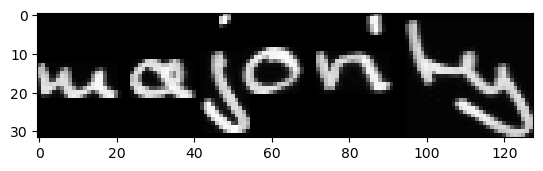



original_text =   of
predicted text = of

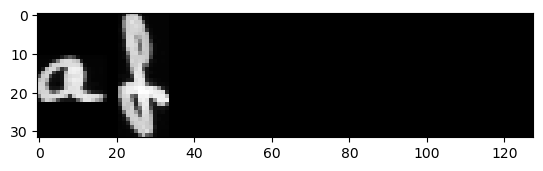



original_text =   Labour
predicted text = Labou

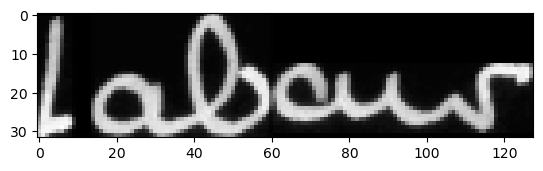



original_text =   MPs
predicted text = MP

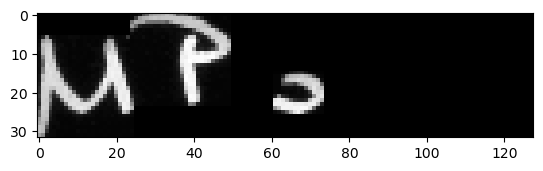



original_text =   are
predicted text = a

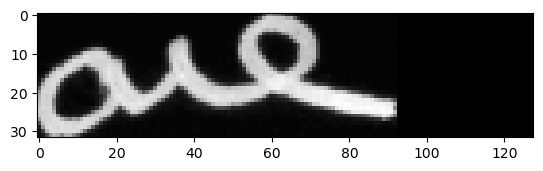



original_text =   to
predicted text = to

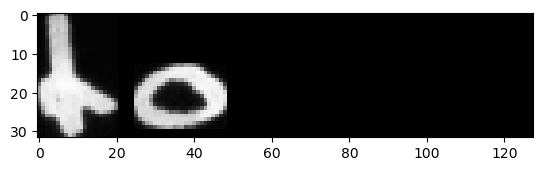



original_text =   turn
predicted text = f

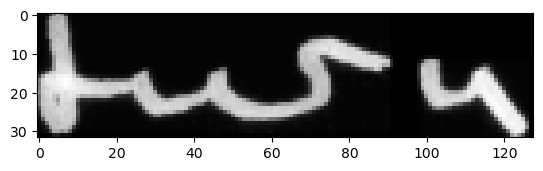



original_text =   down
predicted text = fo

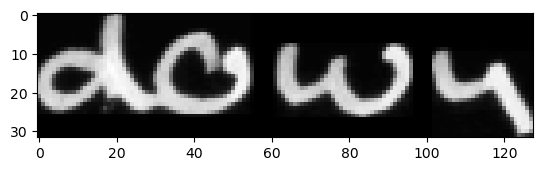



original_text =   the
predicted text = th

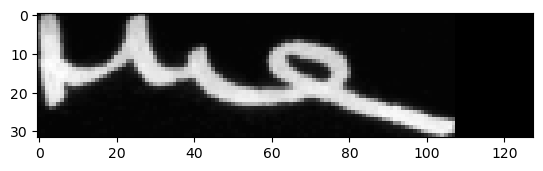



original_text =   Foot-
predicted text = Fot

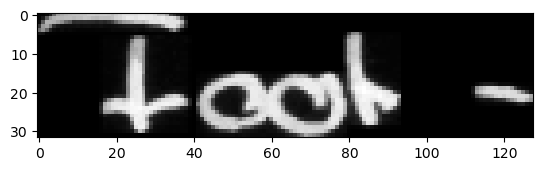



original_text =   be
predicted text = be

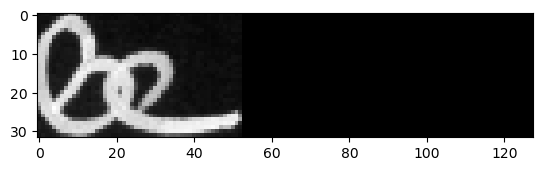



original_text =   that
predicted text = t

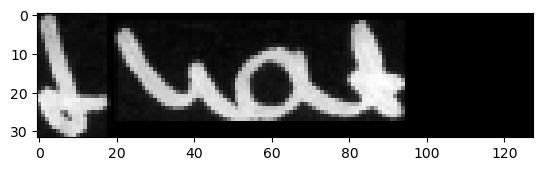



original_text =   as
predicted text = an

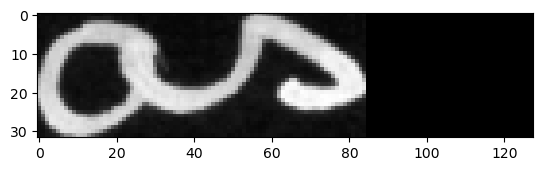



original_text =   Labour
predicted text = Labo

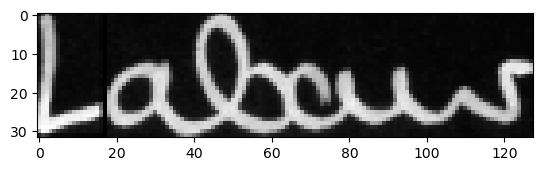



original_text =   MPs
predicted text = MPs

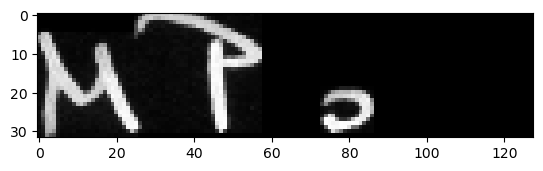



original_text =   opposed
predicted text = pt

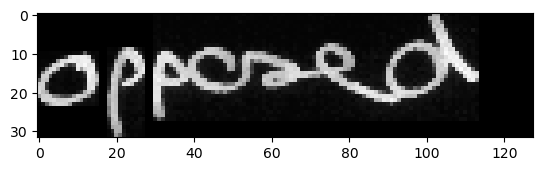



original_text =   the
predicted text = th

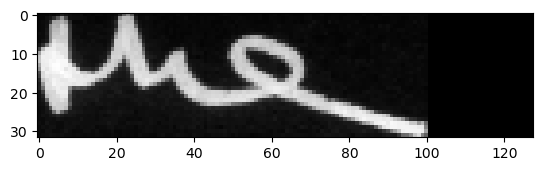



original_text =   Bill
predicted text = B

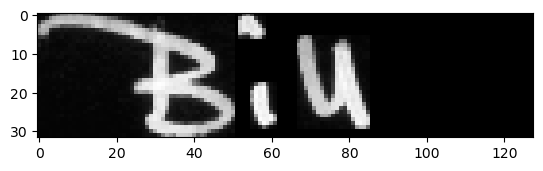



original_text =   which
predicted text = Loi

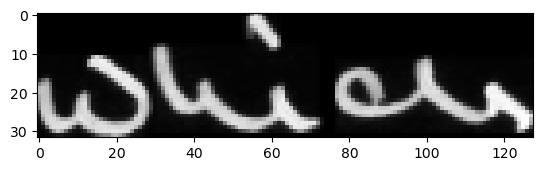



original_text =   brought
predicted text = mo

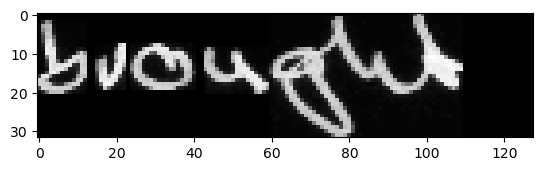



original_text =   life
predicted text = lif

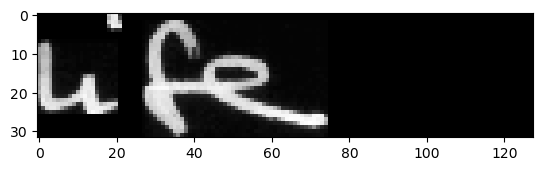



original_text =   peers
predicted text = p

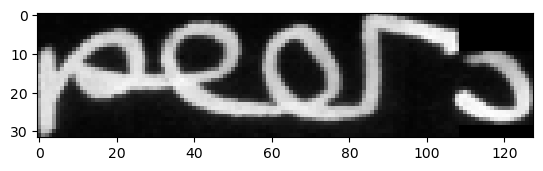



original_text =   into
predicted text = into

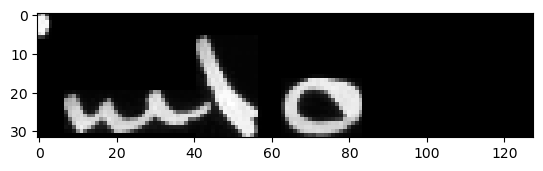



original_text =   existence
predicted text = set

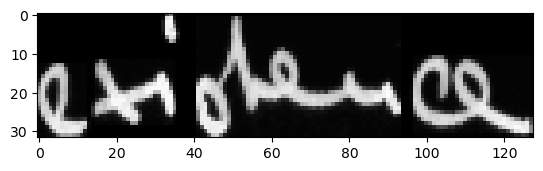



original_text =   ,
predicted text = ,

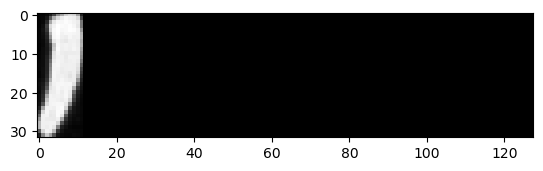



original_text =   they
predicted text = t

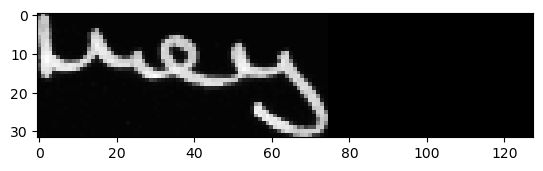



original_text =   not
predicted text = not

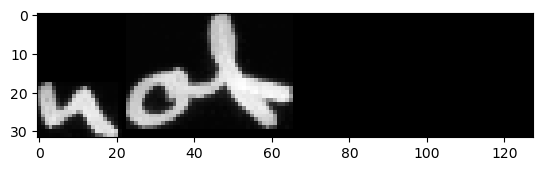



original_text =   now
predicted text = ao

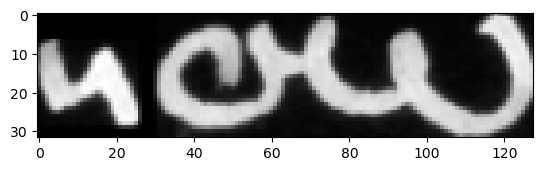



original_text =   put
predicted text = pt

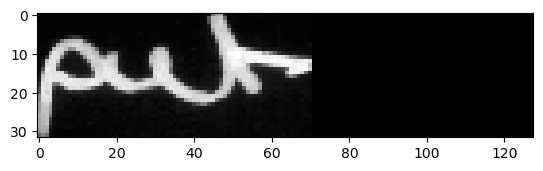



original_text =   forward
predicted text = fo

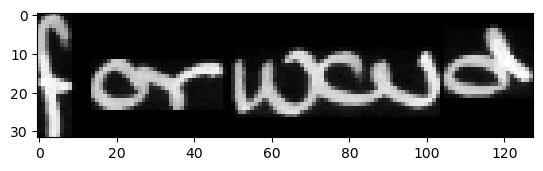



original_text =   nominees
predicted text = ei

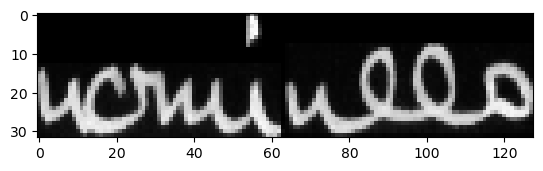



original_text =   .
predicted text = .

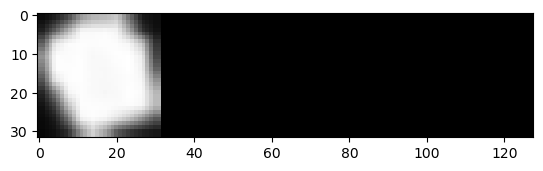



original_text =   He
predicted text = te

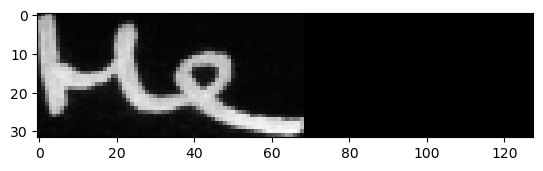



original_text =   believes
predicted text = net

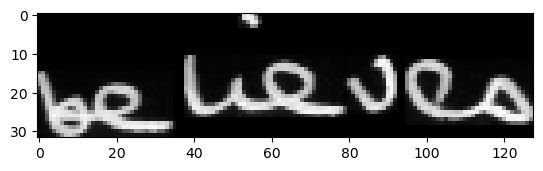



original_text =   that
predicted text = tat

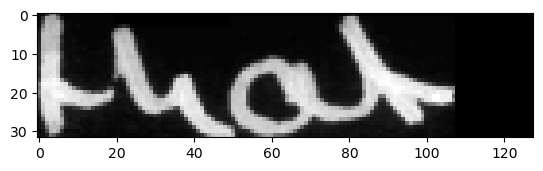



original_text =   House
predicted text = Ho

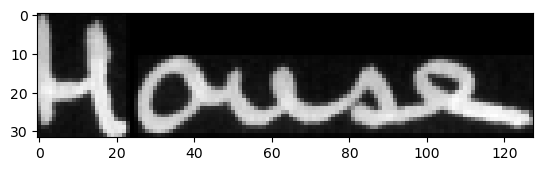



original_text =   of
predicted text = of

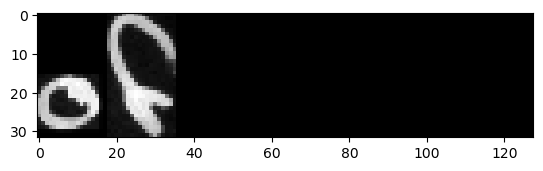



original_text =   Lords
predicted text = Lo

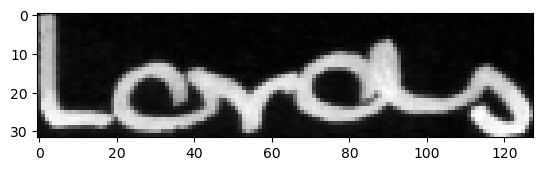



original_text =   should
predicted text = so

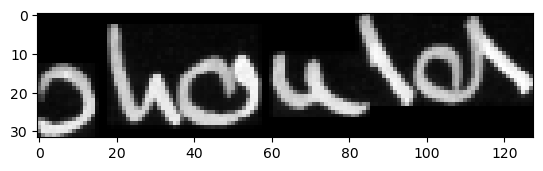



original_text =   be
predicted text = be

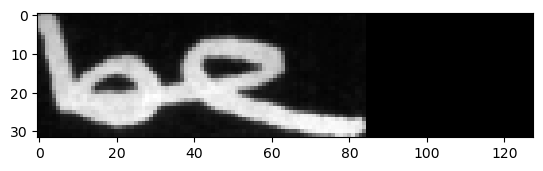



original_text =   abolished
predicted text = aboit

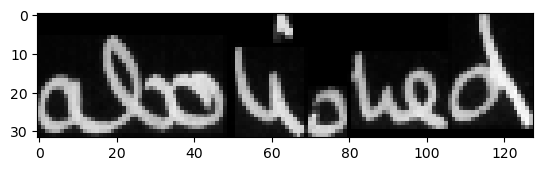



original_text =   and
predicted text = a

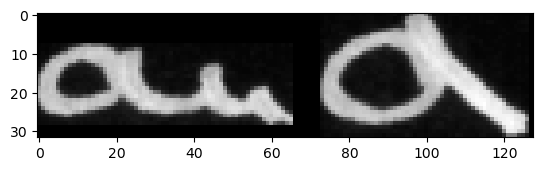



original_text =   that
predicted text = tt

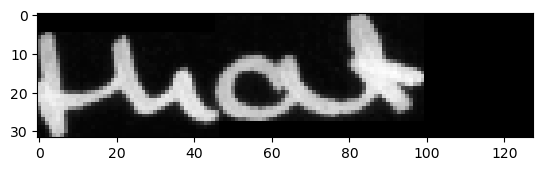



original_text =   Labour
predicted text = Lbo

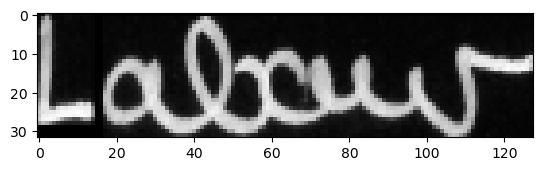



original_text =   not
predicted text = not

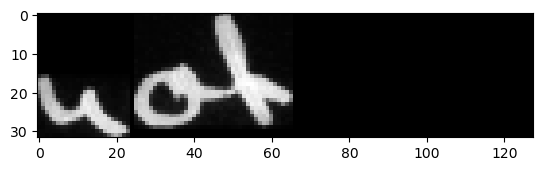



original_text =   take
predicted text = t

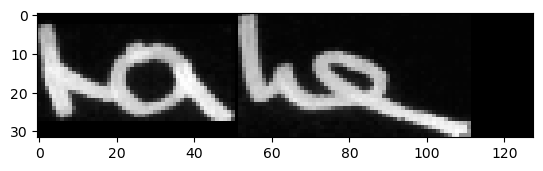



original_text =   any
predicted text = a

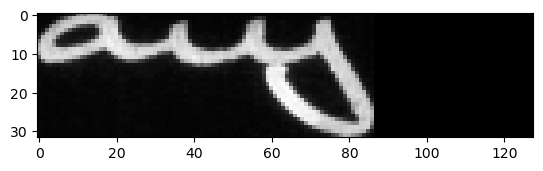



original_text =   steps
predicted text = t

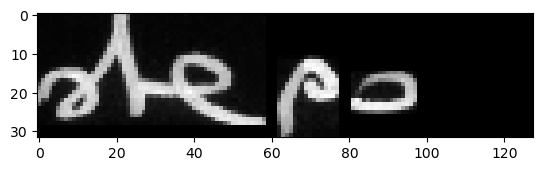



original_text =   which
predicted text = sw

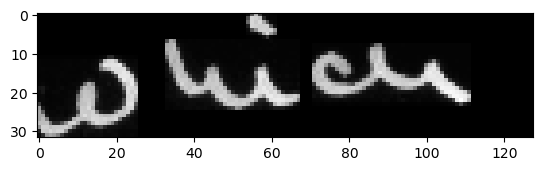



original_text =   would
predicted text = wo

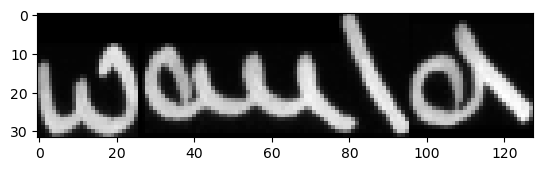



original_text =   appear
predicted text = p

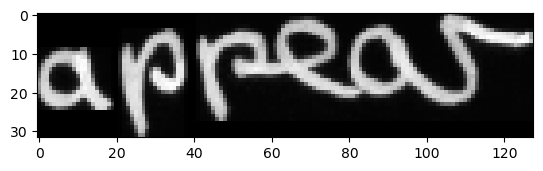



original_text =   to
predicted text = to

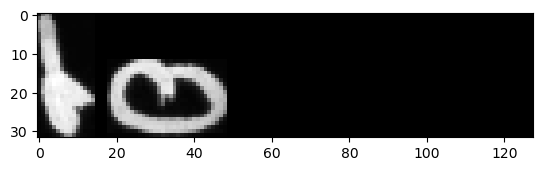



original_text =   "
predicted text = "

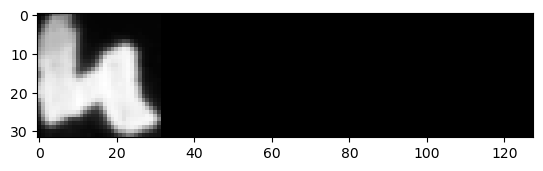



original_text =   up
predicted text = p

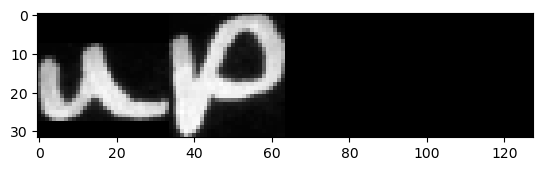



original_text =   "
predicted text = .

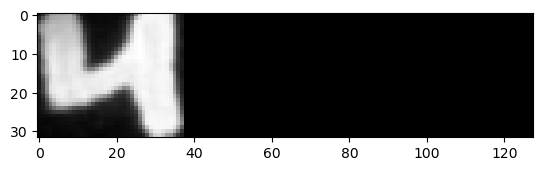



original_text =   an
predicted text = an

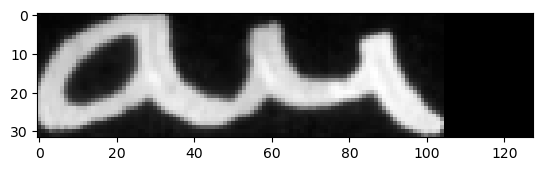



original_text =   out-
predicted text = nt

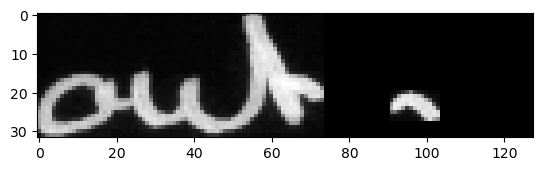



original_text =   large
predicted text = fre

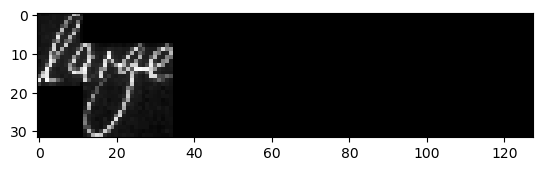



original_text =   majority
predicted text = mjit

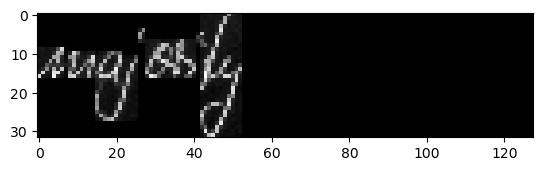



original_text =   of
predicted text = f

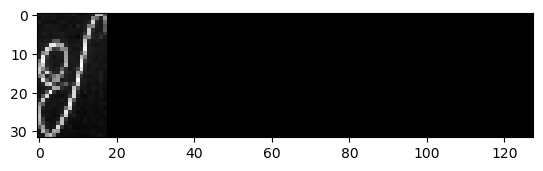



original_text =   Labour
predicted text = Lbo

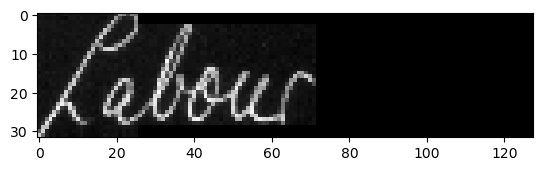



original_text =   0MPs
predicted text = MP

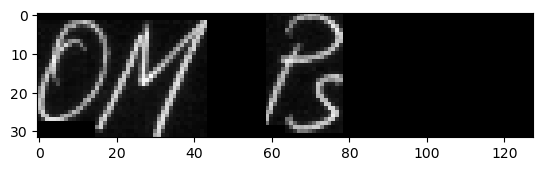



original_text =   are
predicted text = Ma

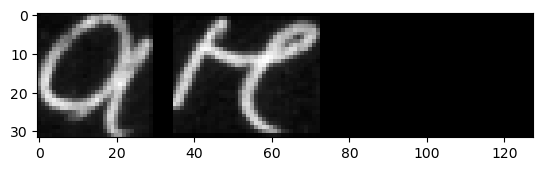



original_text =   to
predicted text = tof

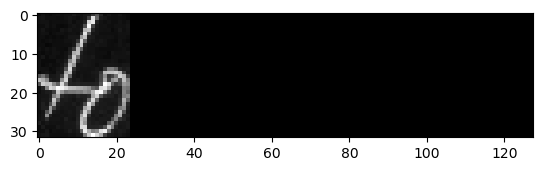



original_text =   turn
predicted text = ta

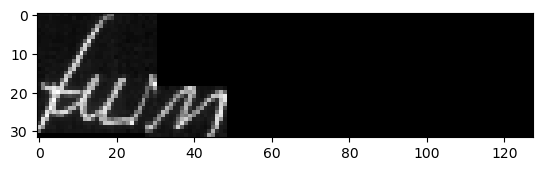



original_text =   Bill
predicted text = 1il

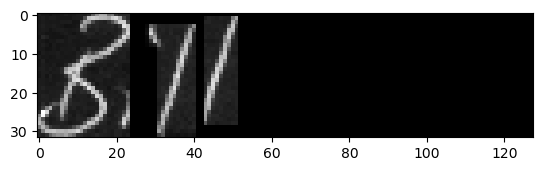



original_text =   which
predicted text = whi

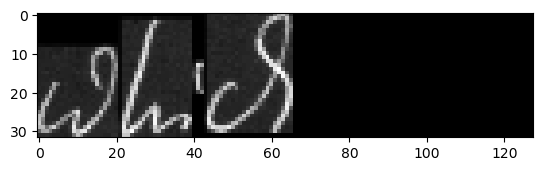



original_text =   brought
predicted text = frut

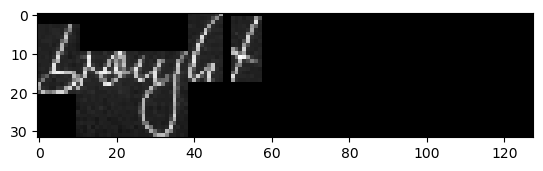



original_text =   life
predicted text = lif

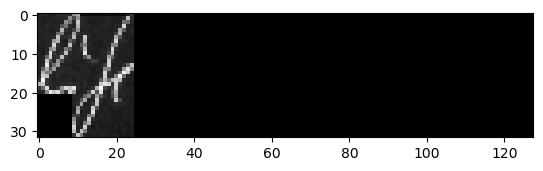



original_text =   peers
predicted text = p

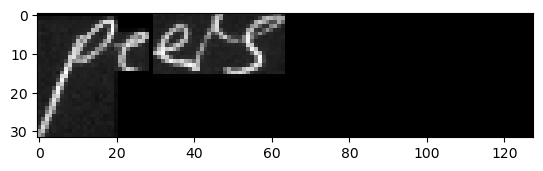



original_text =   into
predicted text = tio

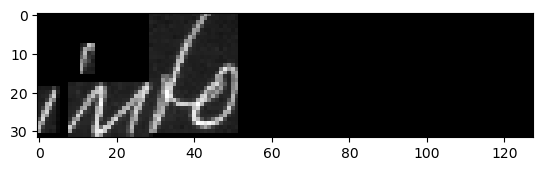



original_text =   existence
predicted text = et

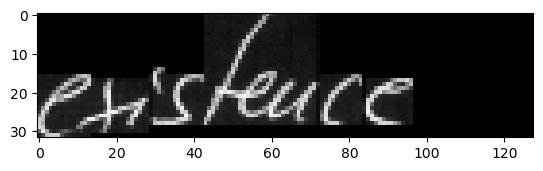



original_text =   ,
predicted text = ,

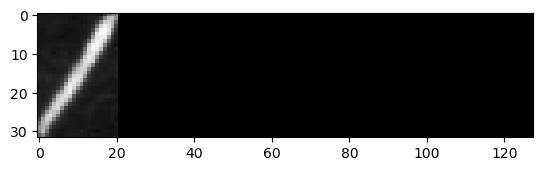



original_text =   they
predicted text = lie

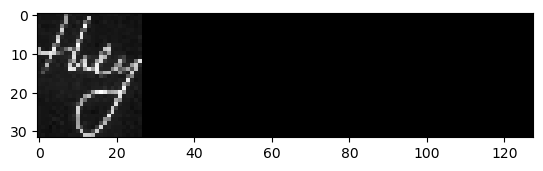



original_text =   not
predicted text = not

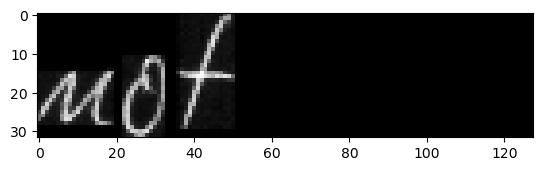



original_text =   now
predicted text = wo

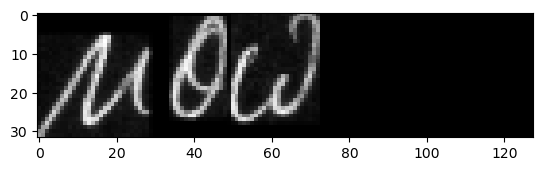



original_text =   put
predicted text = put

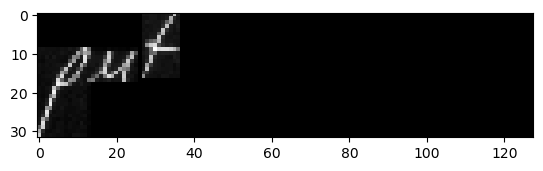



original_text =   forward
predicted text = fr

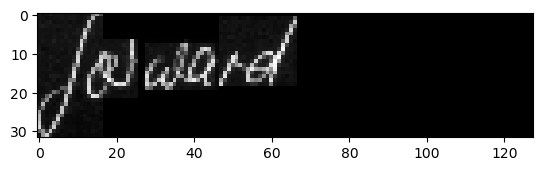



original_text =   nominees
predicted text = no

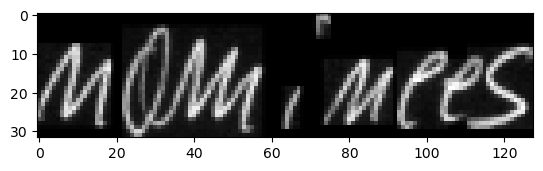



original_text =   .
predicted text = .

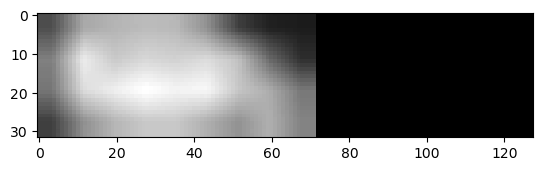



original_text =   He
predicted text = to

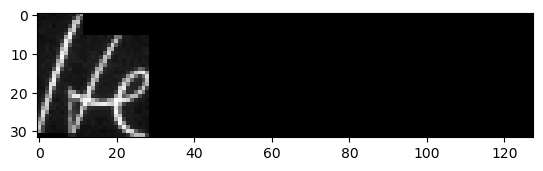



original_text =   believes
predicted text = Lbo

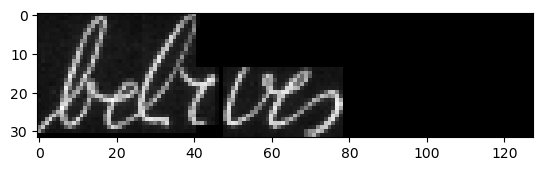



original_text =   that
predicted text = tao

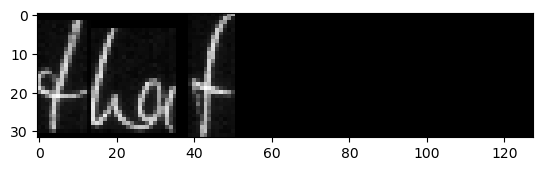



original_text =   House
predicted text = Lou

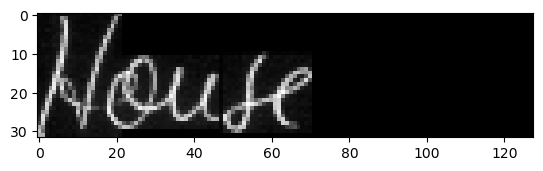



original_text =   of
predicted text = f

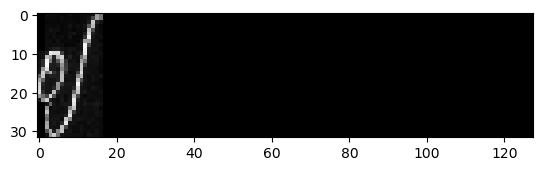



original_text =   Lords
predicted text = Lao

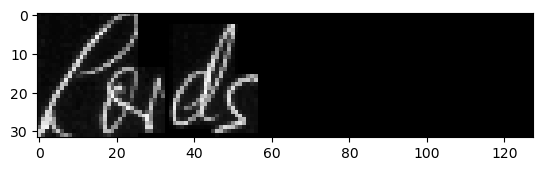



original_text =   should
predicted text = shol

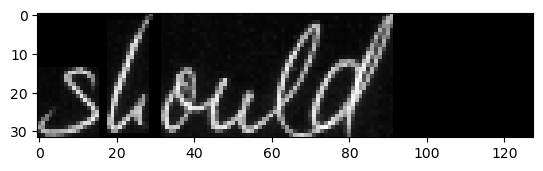



original_text =   be
predicted text = to

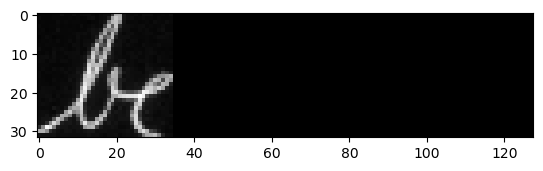



original_text =   abolished
predicted text = Lao

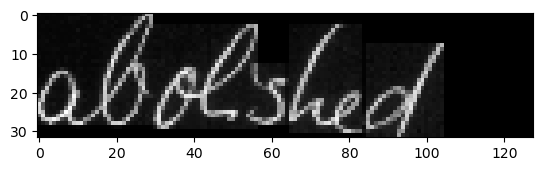



original_text =   and
predicted text = n

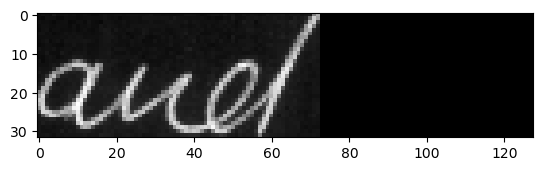



original_text =   that
predicted text = ta

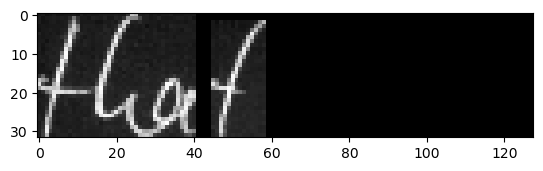



original_text =   Labour
predicted text = Labo

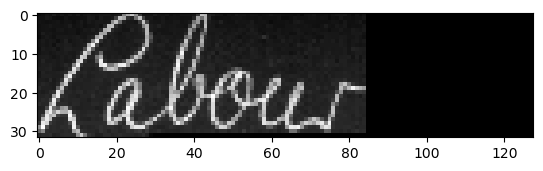



original_text =   not
predicted text = not

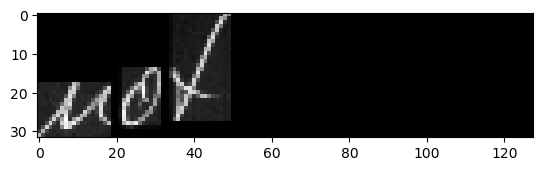



original_text =   take
predicted text = t

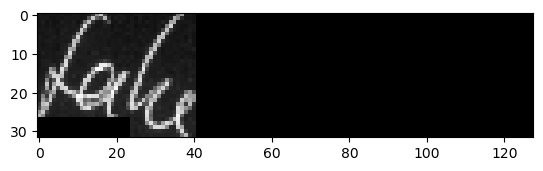



original_text =   any
predicted text = a

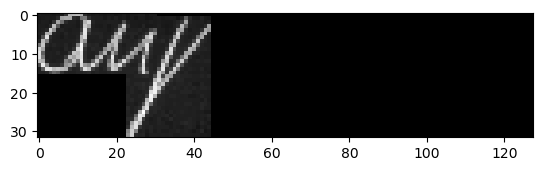



original_text =   steps
predicted text = tfe

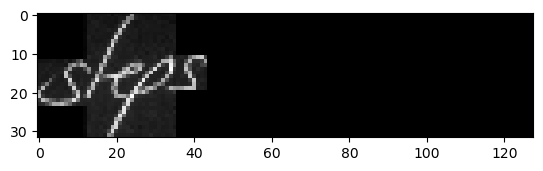



original_text =   which
predicted text = whi

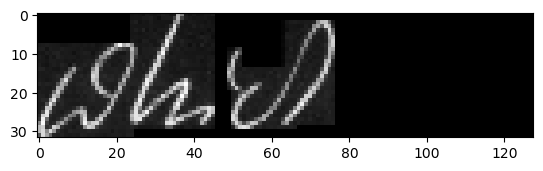



original_text =   would
predicted text = wol

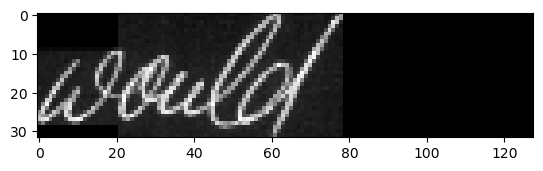



original_text =   appear
predicted text = p

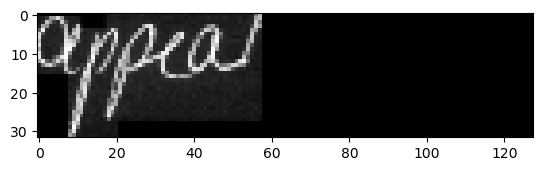



original_text =   to
predicted text = to

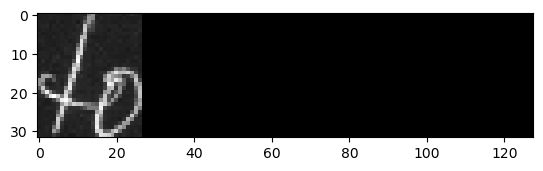



original_text =   "
predicted text = ,

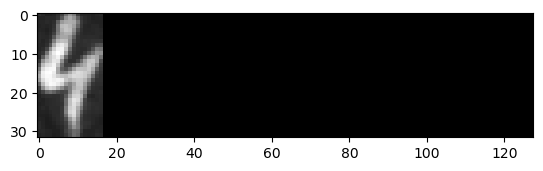



original_text =   up
predicted text = p

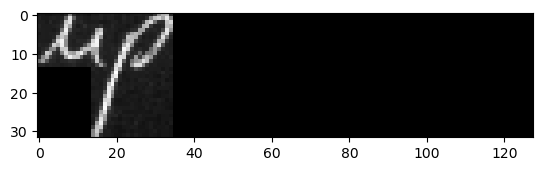



original_text =   "
predicted text = "

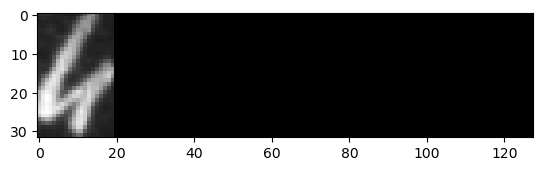



original_text =   an
predicted text = Mo

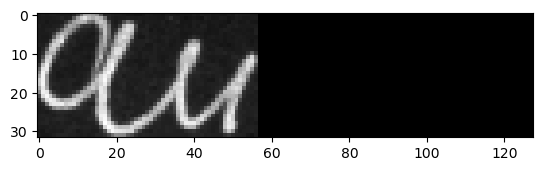



original_text =   out-dated
predicted text = at

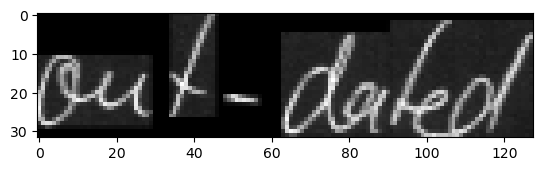



original_text =   institution
predicted text = st

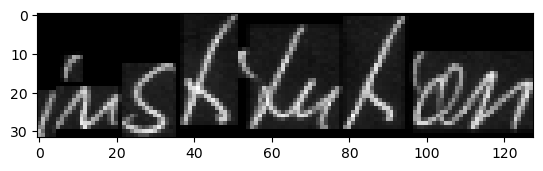



original_text =   .
predicted text = .

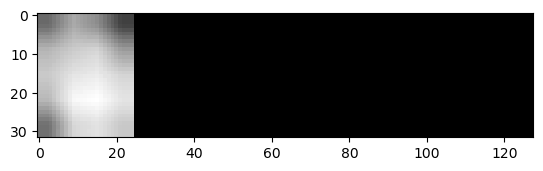



original_text =   Since
predicted text = Si

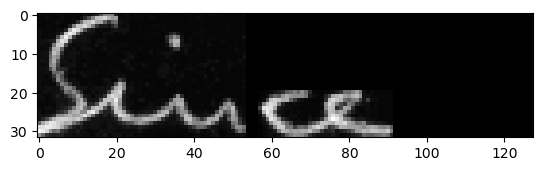



original_text =   1958
predicted text = 19

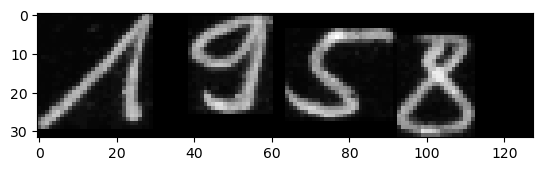



original_text =   ,
predicted text = ,

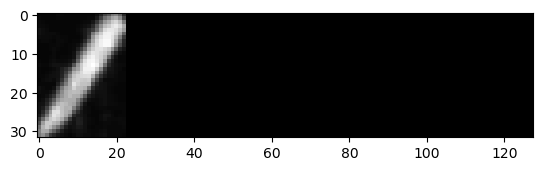



original_text =   Labour
predicted text = Labo

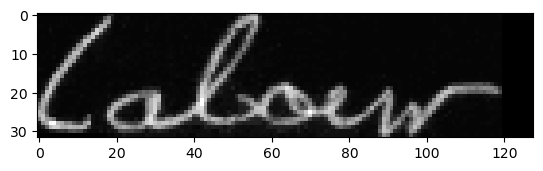



original_text =   life
predicted text = lif

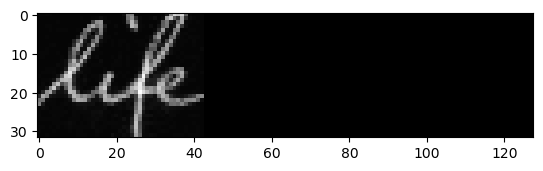



original_text =   Peers
predicted text = P

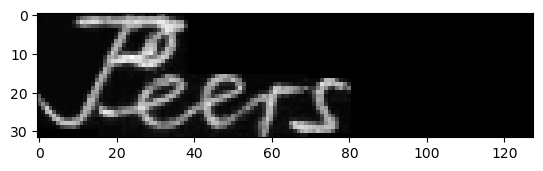



original_text =   and
predicted text = net

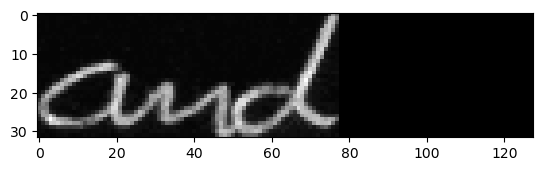



original_text =   Peeresses
predicted text = Pe

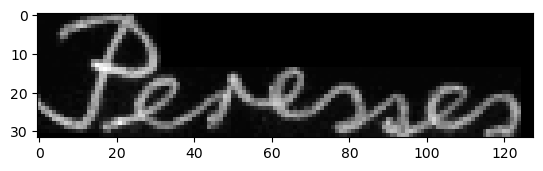



original_text =   have
predicted text = bo

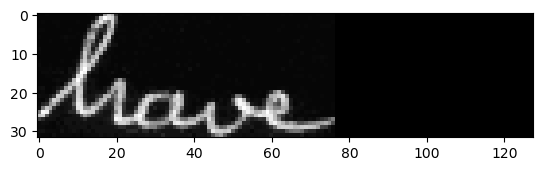



original_text =   been
predicted text = b

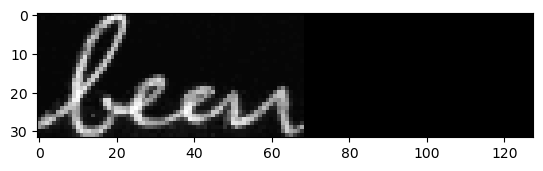



original_text =   created
predicted text = et

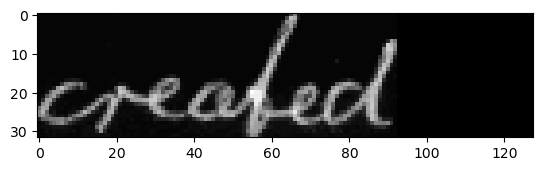



original_text =   .
predicted text = .

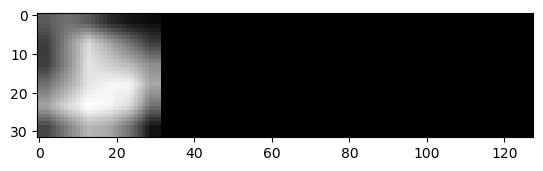



original_text =   Labour
predicted text = Laboo

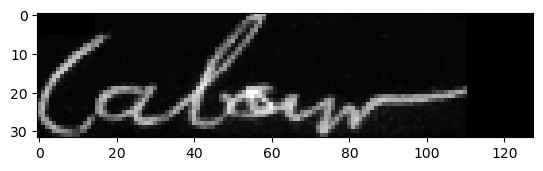



original_text =   sentiment
predicted text = ett

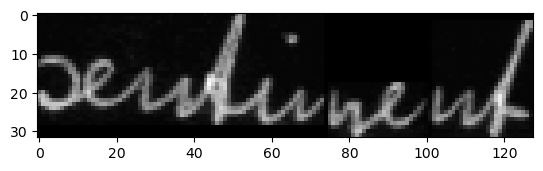



original_text =   would
predicted text = iol

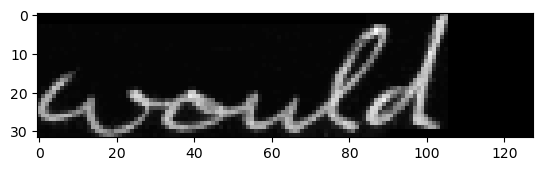



original_text =   #
predicted text = t

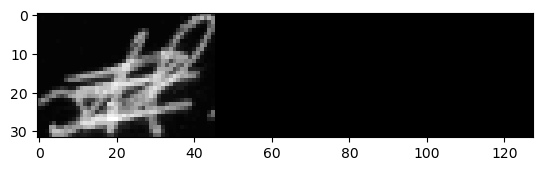



original_text =   still
predicted text = sil

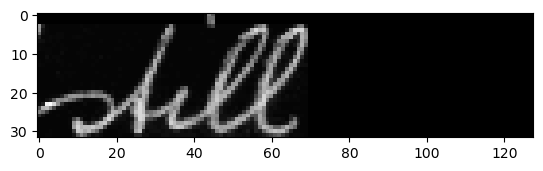



original_text =   favour
predicted text = fo

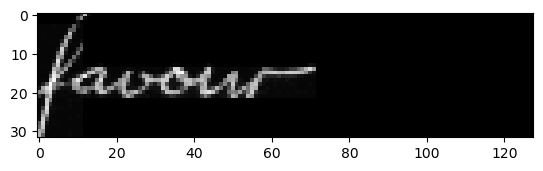



original_text =   the
predicted text = to

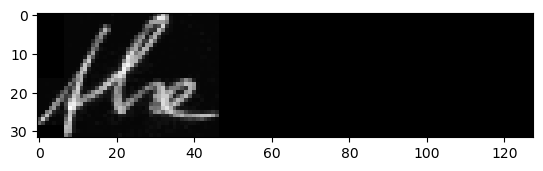



original_text =   abolition
predicted text = sbo

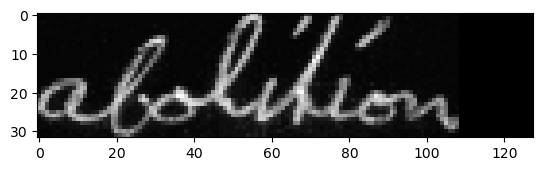



original_text =   of
predicted text = of

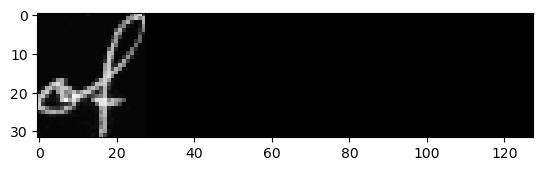



original_text =   House
predicted text = tou

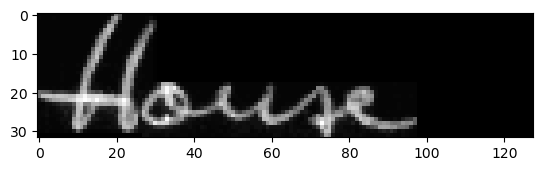



original_text =   of
predicted text = of

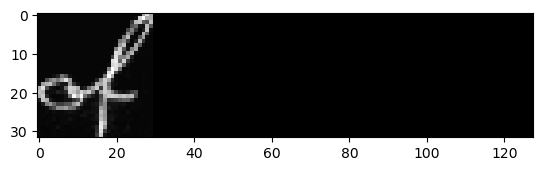



original_text =   Lords
predicted text = Laot

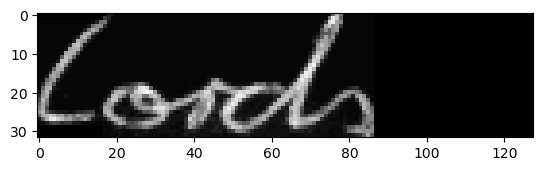



original_text =   ,
predicted text = ,

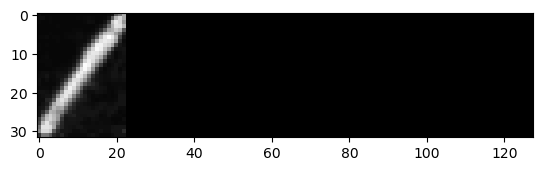



original_text =   but
predicted text = to

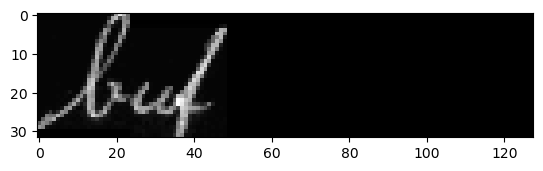



original_text =   while
predicted text = si

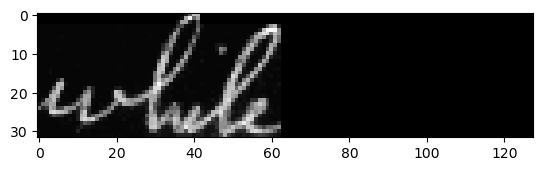



original_text =   it
predicted text = t

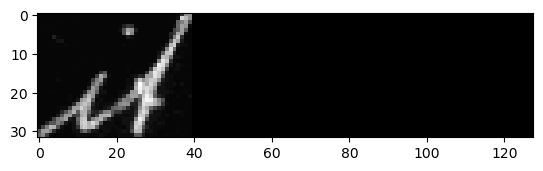



original_text =   remains
predicted text = e

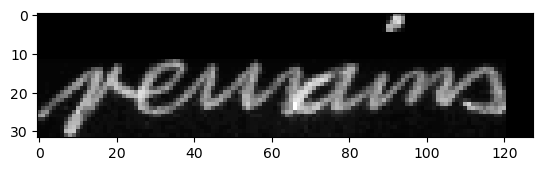



original_text =   Labour
predicted text = Labo

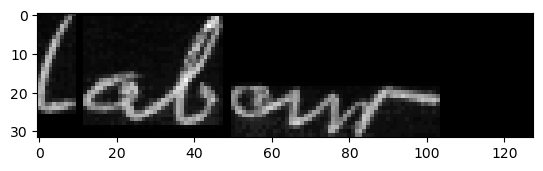



original_text =   to
predicted text = to

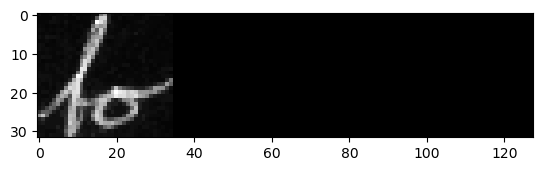



original_text =   have
predicted text = Lbo

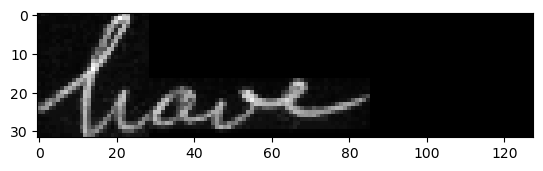



original_text =   an
predicted text = a

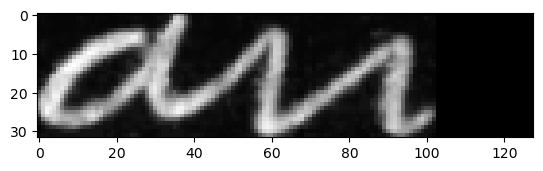



original_text =   adequate
predicted text = mot

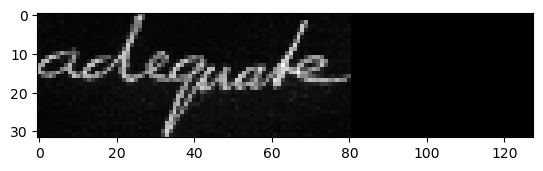



original_text =   number
predicted text = eb

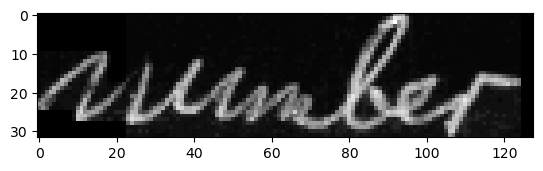



original_text =   of
predicted text = of

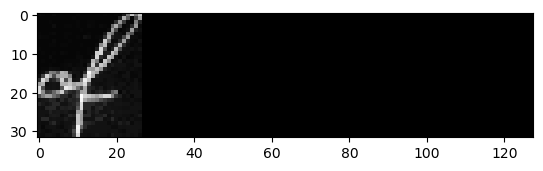



original_text =   members
predicted text = meb

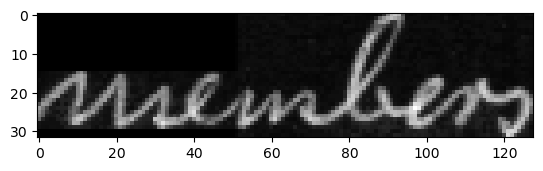



original_text =   .
predicted text = .

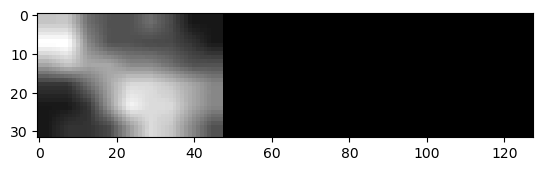



original_text =   THE
predicted text = T

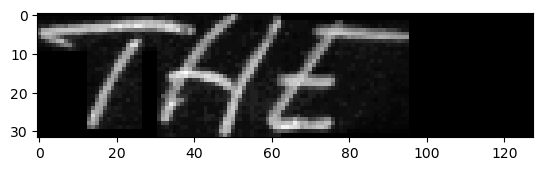



original_text =   rival
predicted text = re

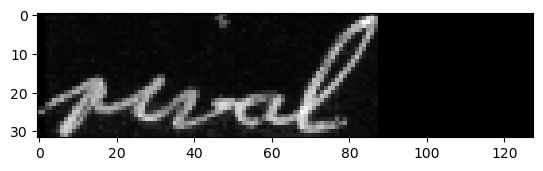



original_text =   African
predicted text = f

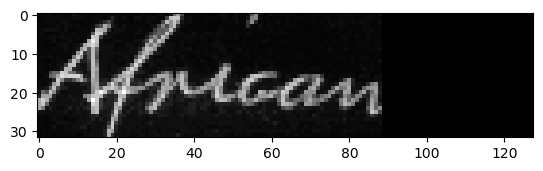



original_text =   Nationalist
predicted text = Laot

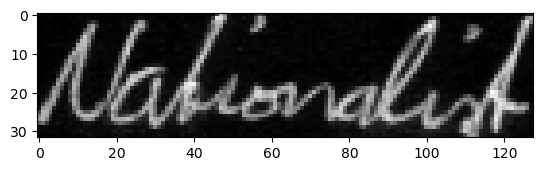



original_text =   Parties
predicted text = Fao

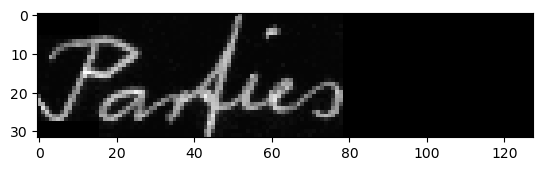



original_text =   of
predicted text = of

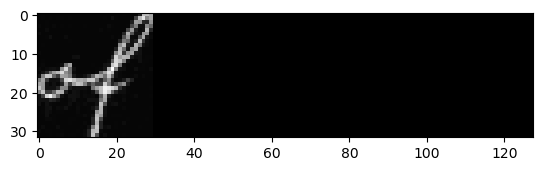



original_text =   Northern
predicted text = Laotu

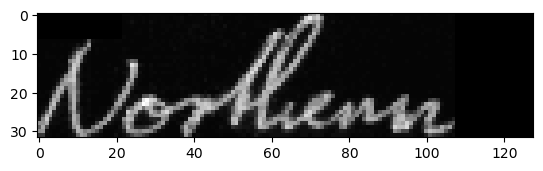



original_text =   Rhodesia
predicted text = Fao

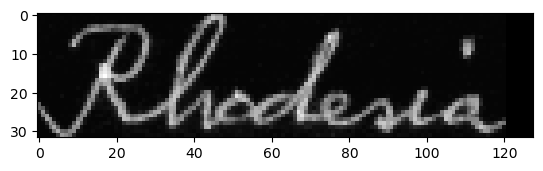



original_text =   have
predicted text = La

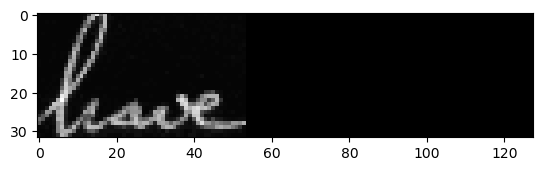



original_text =   agreed
predicted text = aot

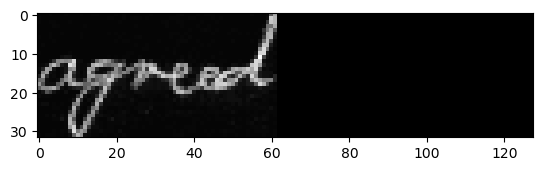



original_text =   get
predicted text = gut

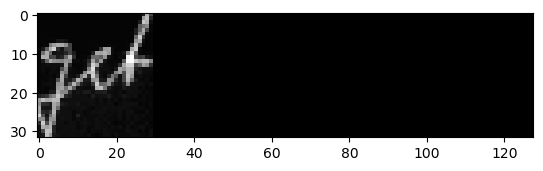



original_text =   together
predicted text = fate

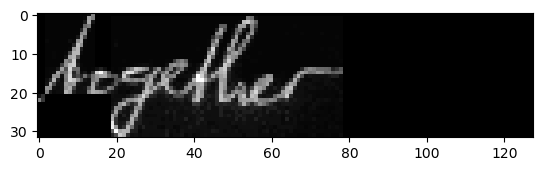



original_text =   to
predicted text = to

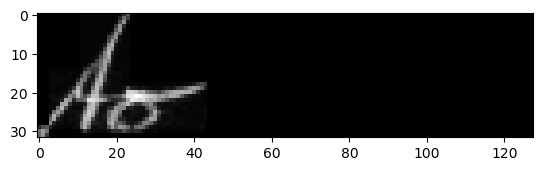



original_text =   face
predicted text = f

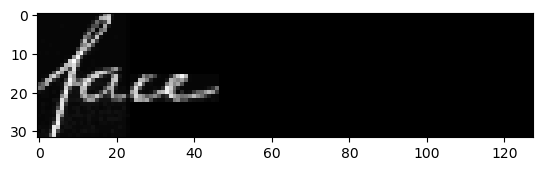



original_text =   the
predicted text = the

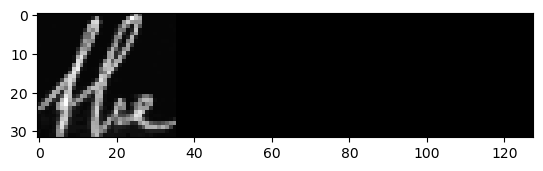



original_text =   challenge
predicted text = fl

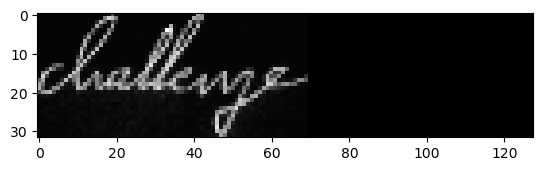



original_text =   from
predicted text = f

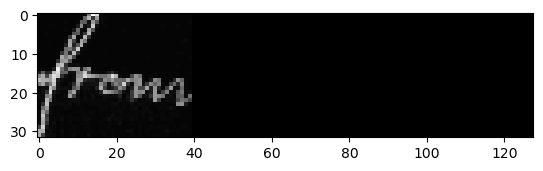



original_text =   Sir
predicted text = i

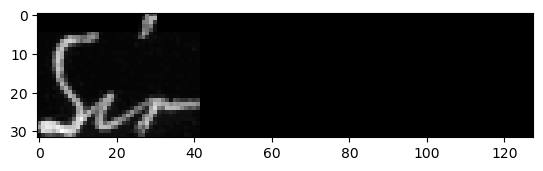



original_text =   Roy
predicted text = bo

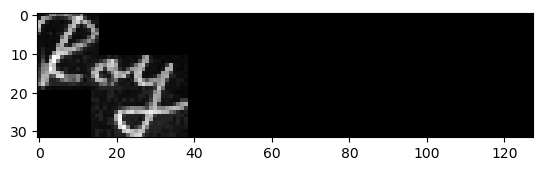



original_text =   ,
predicted text = ,

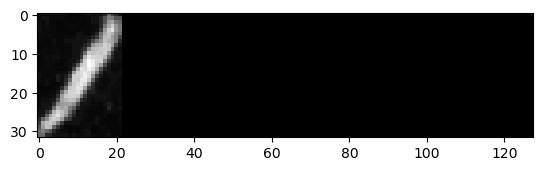



original_text =   the
predicted text = th

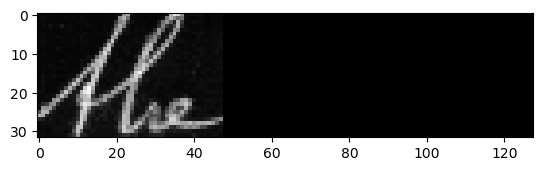



original_text =   Federal
predicted text = Fao

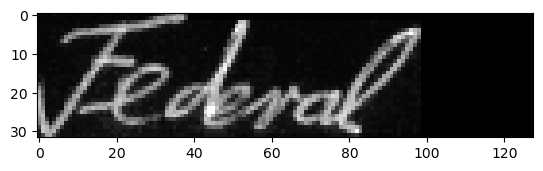



original_text =   Premier
predicted text = Po

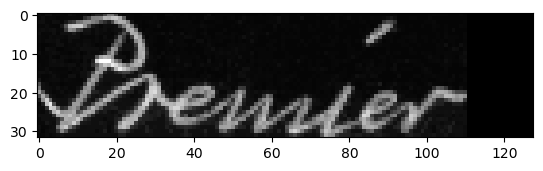



original_text =   .
predicted text = .

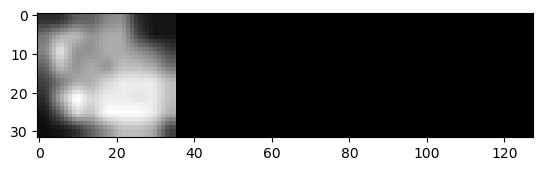



original_text =   Since
predicted text = bo

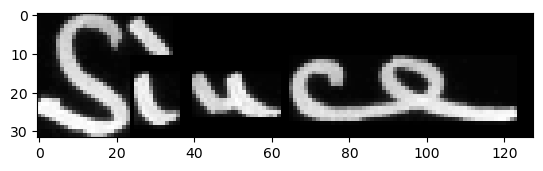



original_text =   1958
predicted text = 15

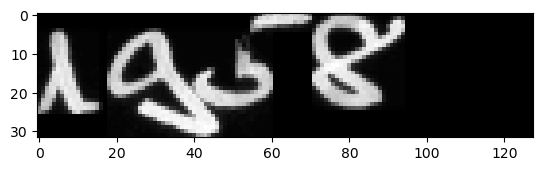



original_text =   ,
predicted text = ,

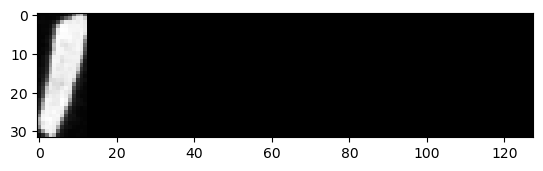



original_text =   13
predicted text = 13

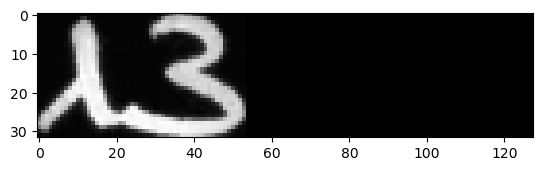



original_text =   life
predicted text = lif

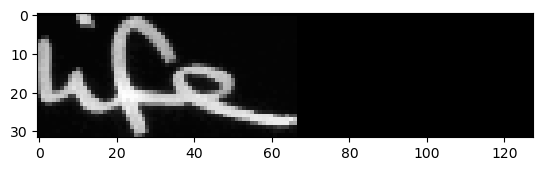



original_text =   Peers
predicted text = P

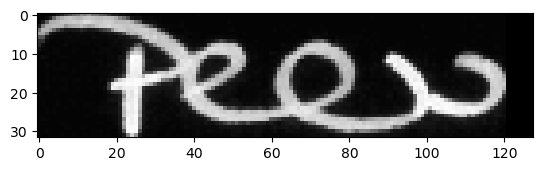



original_text =   and
predicted text = a

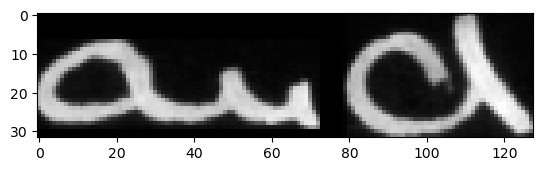



original_text =   Peeresses
predicted text = Pe

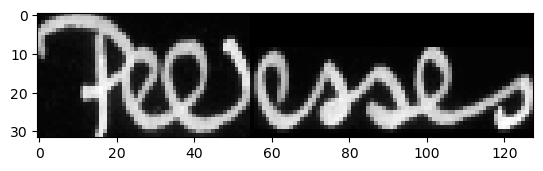



original_text =   have
predicted text = bao

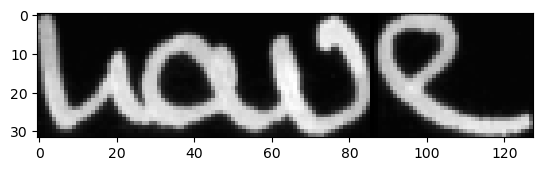



original_text =   been
predicted text = be

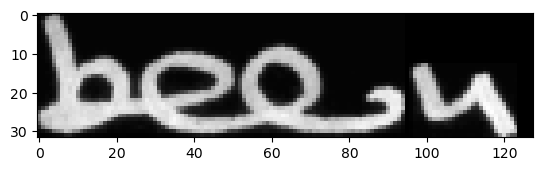



original_text =   created
predicted text = r

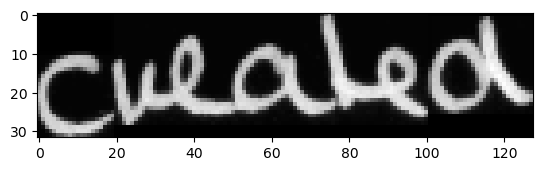



original_text =   .
predicted text = .

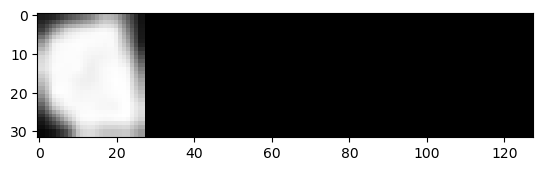



original_text =   Most
predicted text = tot

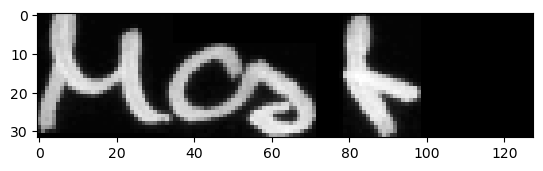



original_text =   sentiment
predicted text = nett

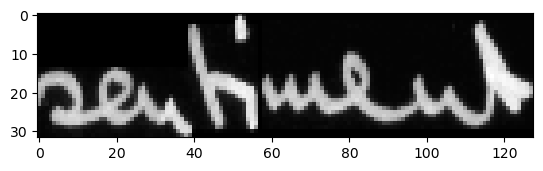



original_text =   would
predicted text = wol

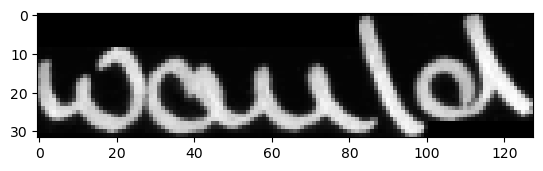



original_text =   still
predicted text = til

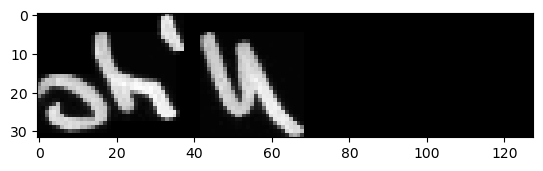



original_text =   favour
predicted text = fo

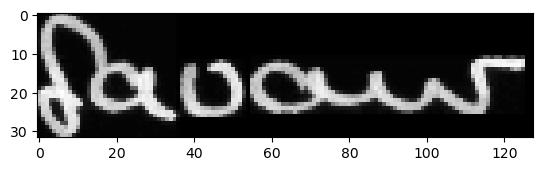



original_text =   the
predicted text = th

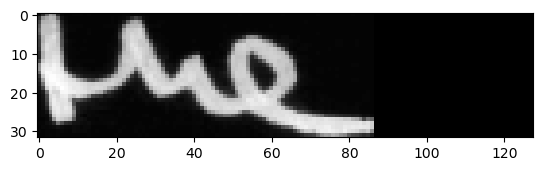



original_text =   abolition
predicted text = abot

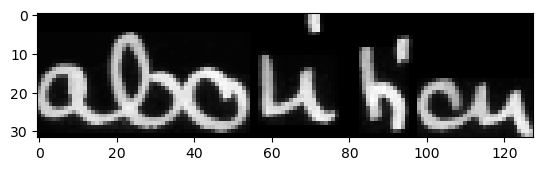



original_text =   of
predicted text = of

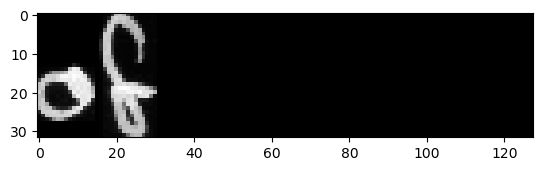



original_text =   the
predicted text = th

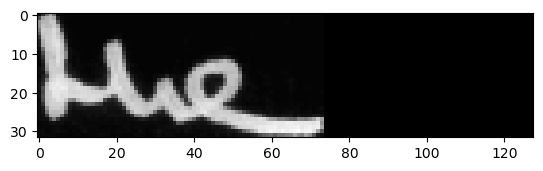



original_text =   House
predicted text = Ho

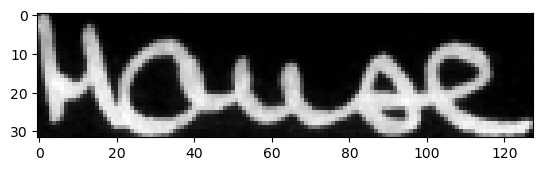



original_text =   Lords
predicted text = Lo

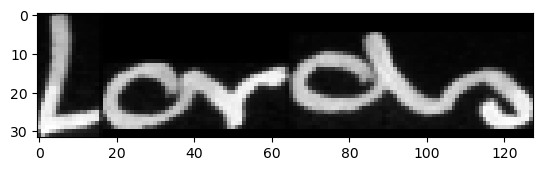



original_text =   ,
predicted text = ,

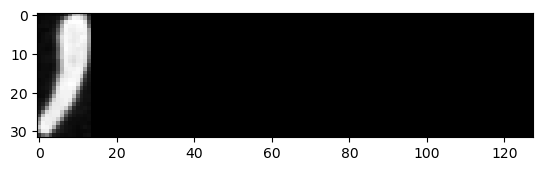



original_text =   but
predicted text = bot

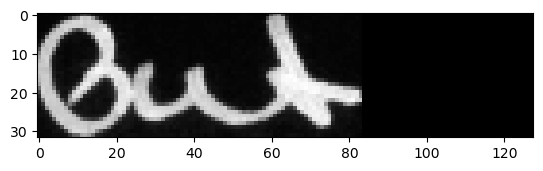



original_text =   while
predicted text = wii

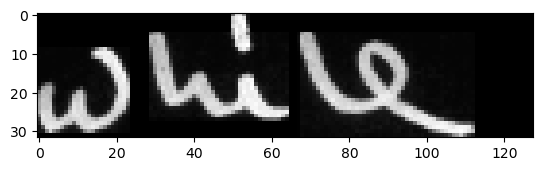



original_text =   it
predicted text = to

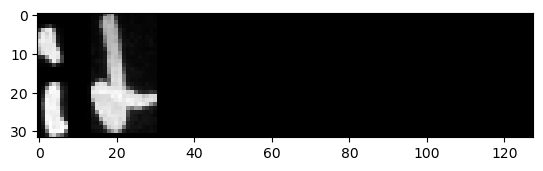



original_text =   remains
predicted text = e

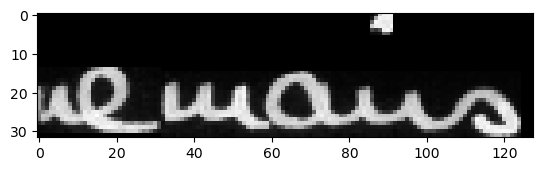



original_text =   Labour
predicted text = Lbou

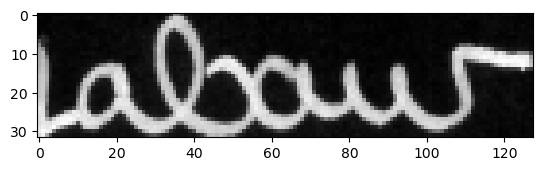



original_text =   has
predicted text = th

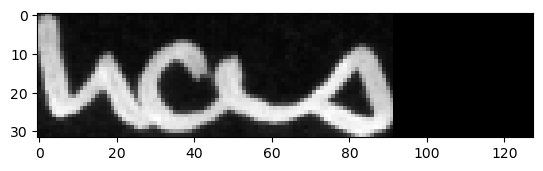



original_text =   to
predicted text = to

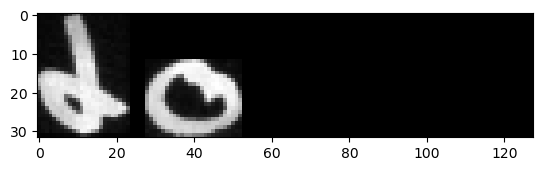



original_text =   an
predicted text = an

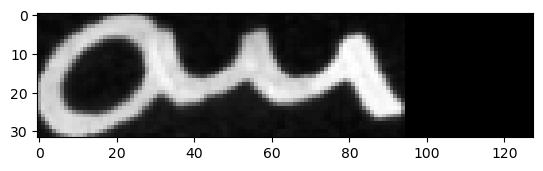



original_text =   adequate
predicted text = set

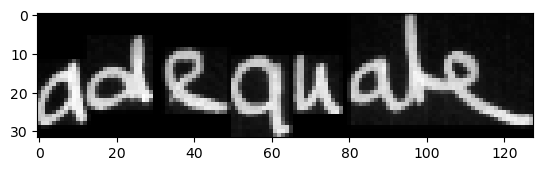



original_text =   number
predicted text = neb

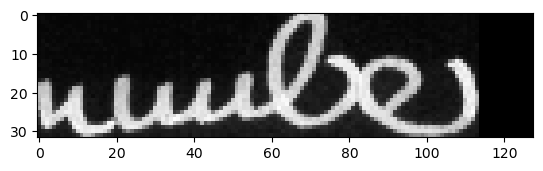



original_text =   of
predicted text = f

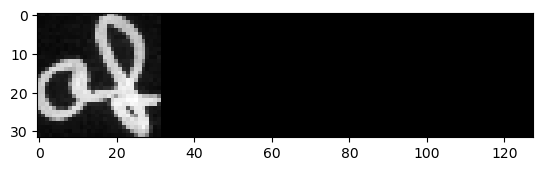



original_text =   members
predicted text = e

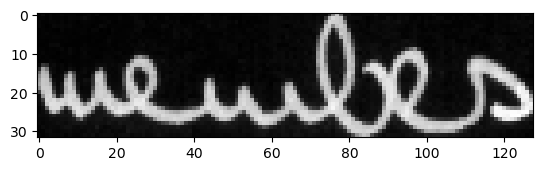



original_text =   .
predicted text = .

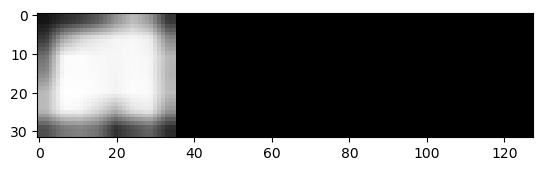



original_text =   THE
predicted text = T

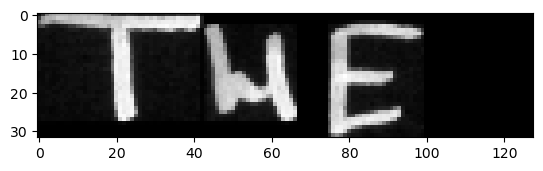



original_text =   two
predicted text = to

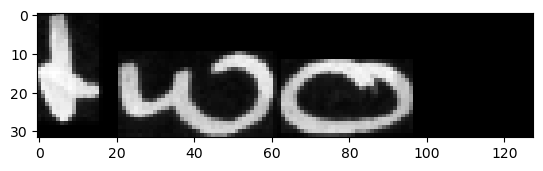



original_text =   rival
predicted text = sil

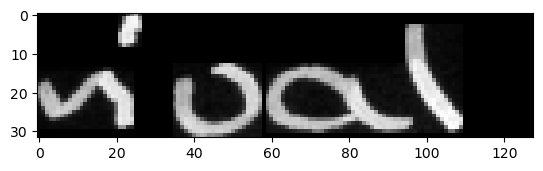



original_text =   Nationalist
predicted text = Laot

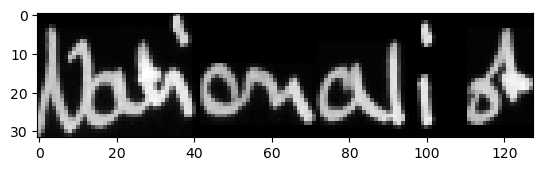



original_text =   Parties
predicted text = Fot

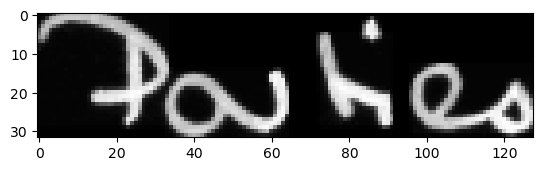



original_text =   of
predicted text = of

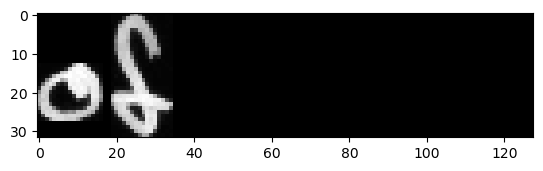



original_text =   Northern
predicted text = Lot

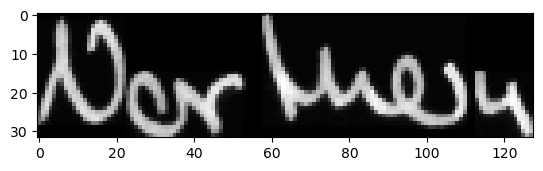



original_text =   Rhodesia
predicted text = Foi

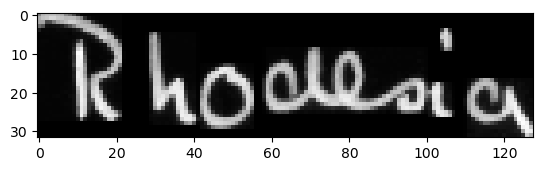



original_text =   have
predicted text = ta

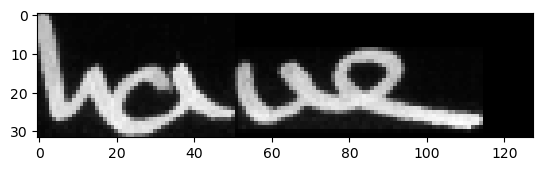



original_text =   agreed
predicted text = a

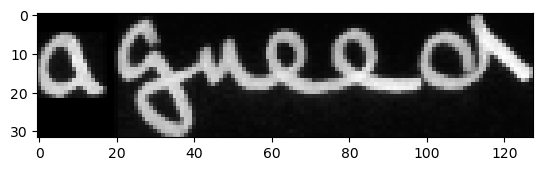



original_text =   to
predicted text = to

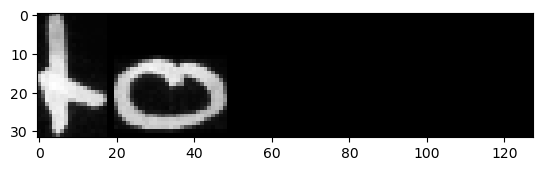



original_text =   get
predicted text = pt

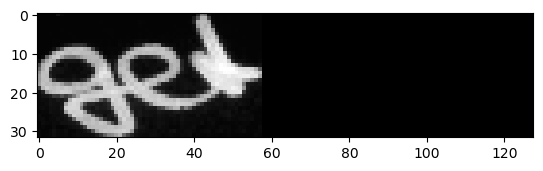



original_text =   to
predicted text = to

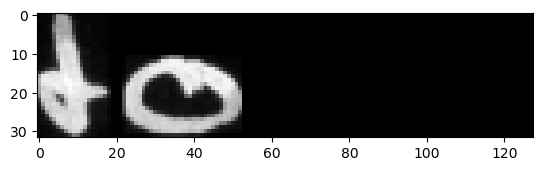



original_text =   face
predicted text = th

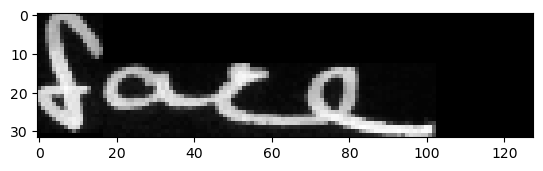



original_text =   the
predicted text = th

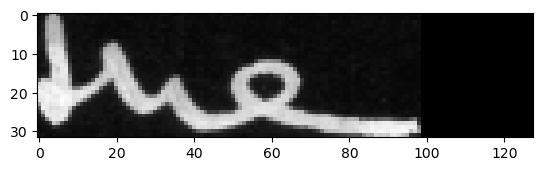



original_text =   challenge
predicted text = a

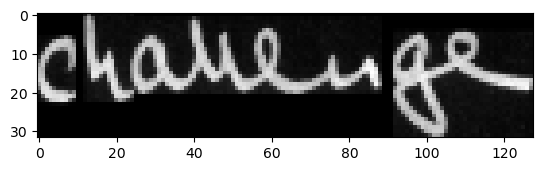



original_text =   from
predicted text = fo

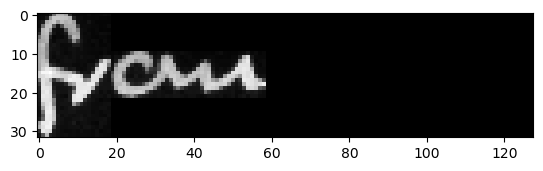



original_text =   Sir
predicted text = Si

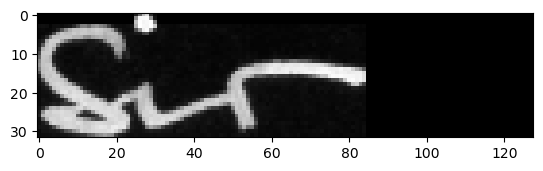



original_text =   Roy
predicted text = Ro

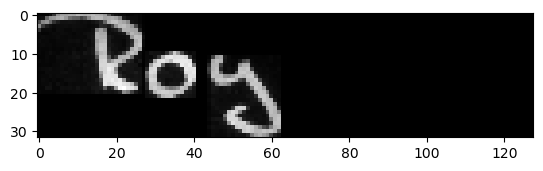



original_text =   Welensky
predicted text = le

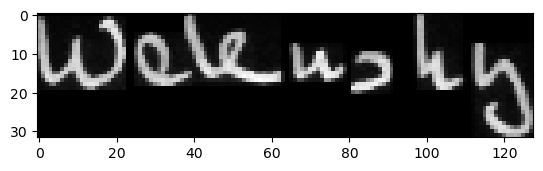



original_text =   ,
predicted text = ,

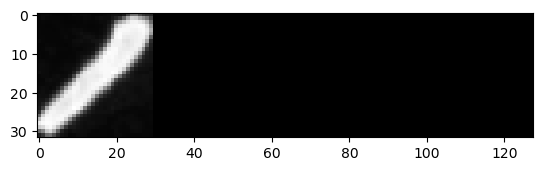



original_text =   Federal
predicted text = Fo

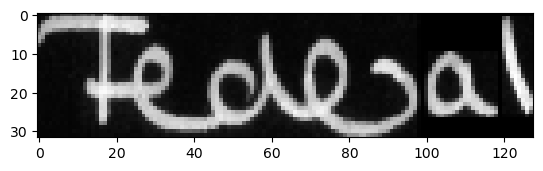



original_text =   Premier
predicted text = P

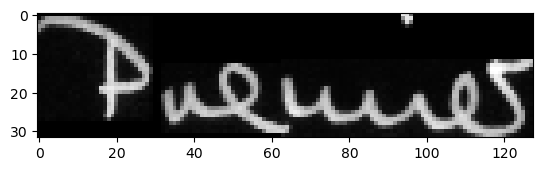



original_text =   .
predicted text = .

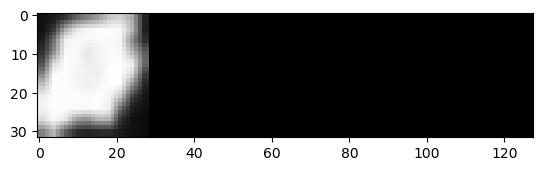



original_text =   Since
predicted text = Lo

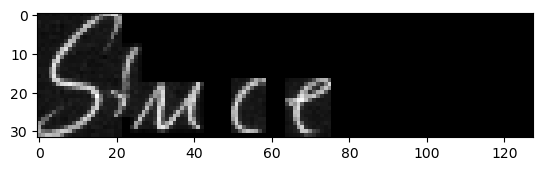



original_text =   1958
predicted text = 15

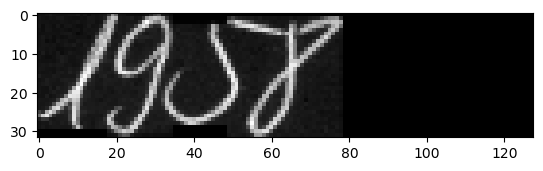



original_text =   ,
predicted text = ,

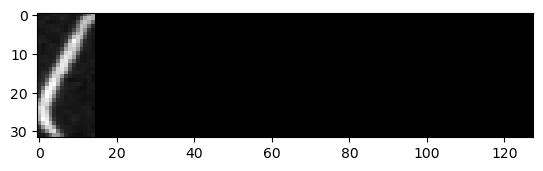



original_text =   13
predicted text = 1

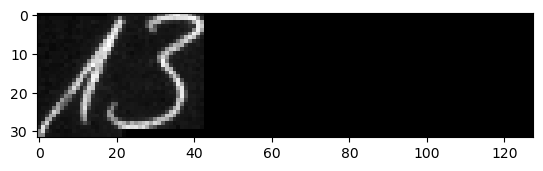



original_text =   Labour
predicted text = Labo

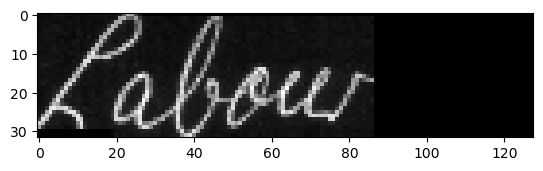



original_text =   life
predicted text = lif

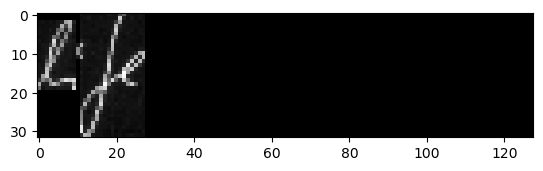



original_text =   and
predicted text = nt

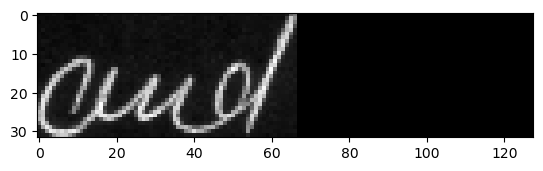



original_text =   #
predicted text = f

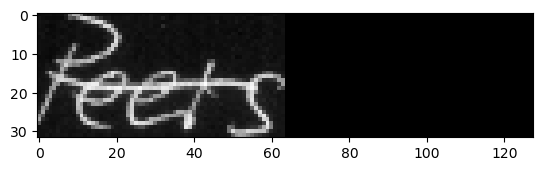



original_text =   Peeresses
predicted text = Pe

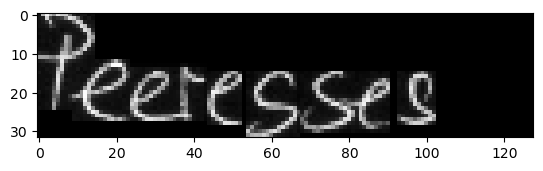



original_text =   have
predicted text = bav

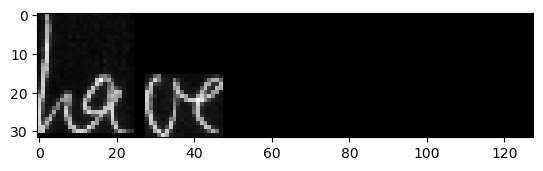



original_text =   been
predicted text = bav

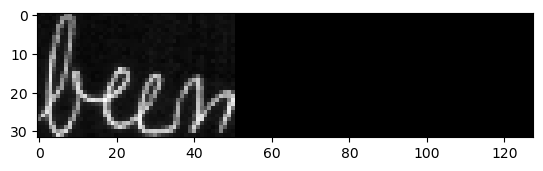



original_text =   created
predicted text = at

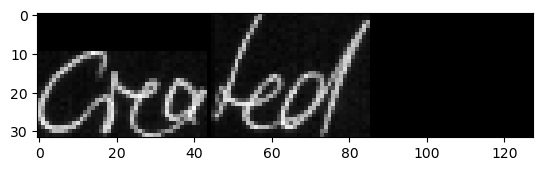



original_text =   .
predicted text = .

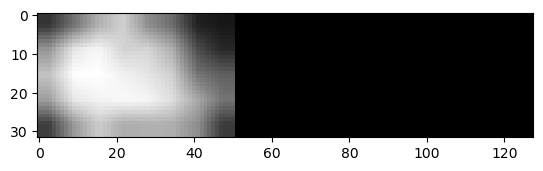



original_text =   Most
predicted text = Mot

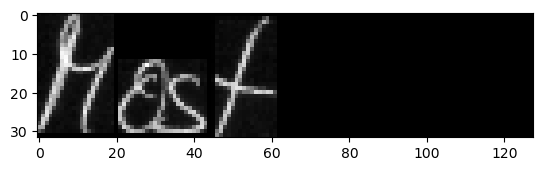



original_text =   Labour
predicted text = Labou

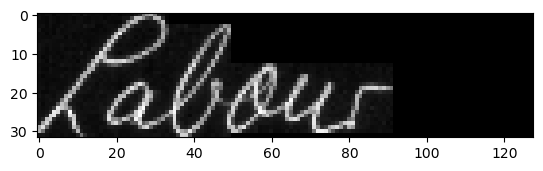

In [23]:
# predict outputs on validation images
prediction =act_model.predict(train_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

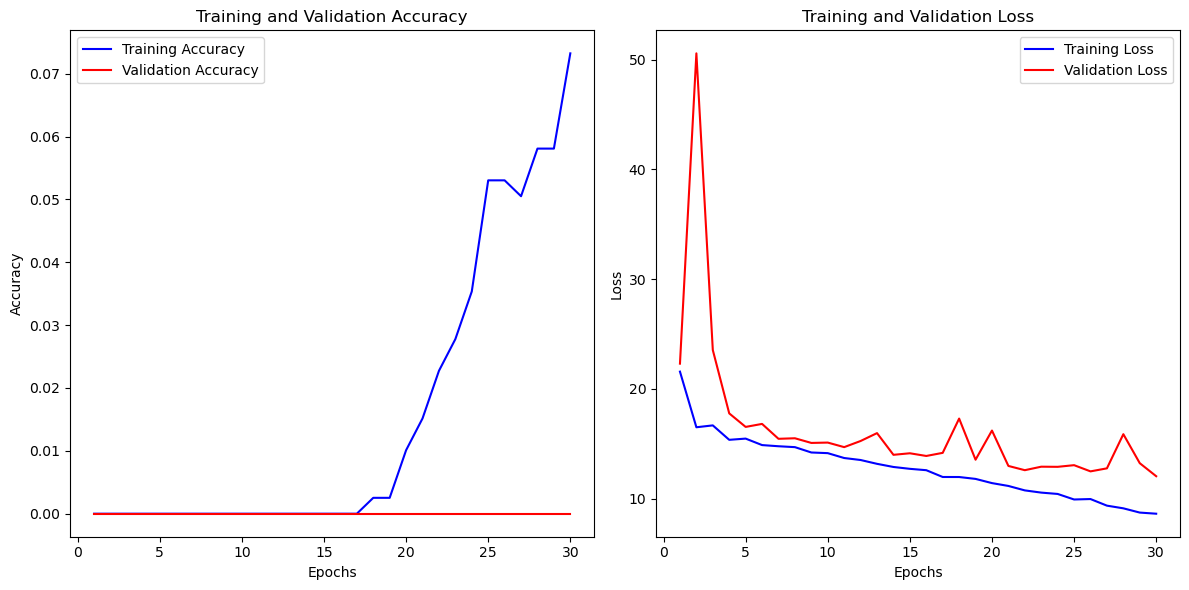

In [24]:
# Extract data from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Save the plot in /kaggle/output/
plot_filename = 'working/Accuracy_Loss_Plot.png'  # Specify the desired file name and extension
plt.savefig(plot_filename)

plt.tight_layout()
plt.show()

In [25]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [26]:
with open('working/history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)

In [27]:
model.save('working/Text_recognizer_Using_CRNN.h5')